In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb
!pip install transformers==4.28.0
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=5942aa1c88fc53d12543295950a4b115e9a0ddf349b256b52704b667a76ddb1b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torchlibrosa
!pip install museval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 64.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
#Path for Audio transformer in this place module can be downloaded from
#https://github.com/RetroCirce/HTS-Audio-Transformer/tree/main
import sys
sys.path.append('/content/drive/MyDrive/ALM_models/HTS-Audio-Transformer-main')

In [ ]:
from model import *

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ALM_models/HTS-Audio-Transformer-main/model')

In [ ]:
from layers import *
from htsat import *

In [ ]:
import config as htsat_cnf

In [ ]:
target_sampling_rate=44100
htsat_cnf.sample_rate=target_sampling_rate

In [ ]:
htsat_cnf.classes_num=512

In [ ]:
import torchaudio
root = './'
train_dataset = torchaudio.datasets.LIBRISPEECH(root, url='train-clean-100', download=True)

100%|██████████| 5.95G/5.95G [07:38<00:00, 13.9MB/s]


In [ ]:
from torch.utils.data import random_split
lengths = [int(len(train_dataset)*0.8),
           int(len(train_dataset)*0.1),
           len(train_dataset) - int(len(train_dataset)*0.8)-int(len(train_dataset)*0.1)]
train_dataset, val_dataset, test_dataset = random_split(train_dataset, lengths)

In [ ]:
gpt2_ckpt='gpt2'
whisper_ckpt='openai/whisper-base'
from transformers import GPT2Tokenizer
tokenizer=GPT2Tokenizer.from_pretrained(gpt2_ckpt)
tokenizer.pad_token=tokenizer.eos_token
from transformers import WhisperFeatureExtractor
feature_extractor=WhisperFeatureExtractor.from_pretrained(whisper_ckpt)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#Dataset class for the model
#returns audio features, labels and the respective prompt
import librosa
import numpy as np
class dataset(Dataset):
  def __init__(self,train_df,feature_extractor,tokenizer):
    super().__init__()
    self.train_df=train_df
    self.feature_extractor=feature_extractor
    self.tokenizer=tokenizer
  def __len__(self):
    return len(self.train_df)
  def __getitem__(self,idx):
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id=self.train_df[idx]
    waveform=waveform[0]
    audio_feats=torch.zeros((sample_rate*7))
    min_len=min(len(waveform),sample_rate*7)
    waveform=torch.tensor(waveform)
    audio_feats[:min_len]=waveform[:min_len].clone().detach()

    audio_feats=np.array(audio_feats)
    original_sample_rate = 16000
    new_sample_rate = 44100
    audio_feats = librosa.resample(audio_feats, orig_sr=original_sample_rate,target_sr=new_sample_rate)
    audio_feats=torch.tensor(audio_feats)
    #audio_feats=self.feature_extractor(waveform[0],sampling_rate=sample_rate,return_tensors='pt')['input_features']

    labels_batch=self.tokenizer(utterance,return_tensors='pt',max_length=200,padding='max_length',truncation=True)
    sum=torch.sum(labels_batch.attention_mask,axis=-1)
    labels_batch.attention_mask[:,sum]=1
    labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

    prompt_ids=self.tokenizer(utterance,return_tensors='pt',max_length=200,padding='max_length',truncation=True)['input_ids']


    audio_feats=torch.squeeze(audio_feats,axis=0).to(device)
    labels=torch.squeeze(labels,axis=0).to(device)
    prompt_ids=torch.squeeze(prompt_ids,axis=0).to(device)

    return audio_feats,labels,prompt_ids

In [ ]:
tr_dataset=dataset(train_dataset,feature_extractor,tokenizer)
val_dataset=dataset(val_dataset,feature_extractor,tokenizer)
test_dataset=dataset(test_dataset,feature_extractor,tokenizer)

train_loader=DataLoader(tr_dataset,batch_size=4,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=4,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=4,shuffle=True)

In [ ]:
import torch.nn as nn
from transformers import AutoConfig
from transformers import GPT2LMHeadModel
#Transformer mapper network
"""Arguments- input-dimension, number of heads, hidden size dimension, number of blocks, input sequence length,
output_sequence length and output dimension.
Projects input to output dimension followed by multiheadself attention and sequence length reduction
"""
class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead, nhid, nlayers, inp_seq_len,out_seq, output_dim):
        super(TransformerModel, self).__init__()

        # Stage 1: Self-attention mechanism that changes the output dimension
        self.encoder = nn.Linear(input_dim, nhid)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(nhid, nhead), nlayers
        )
        self.proj = nn.Linear(nhid, output_dim)

        # Stage 2: Learned positional encoding to change the sequence length
        self.pos_encoder = nn.Linear(inp_seq_len, out_seq)



    def forward(self, src):
        src = self.encoder(src)
        src = self.transformer_encoder(src)
        src = self.proj(src)

        # Adjust the sequence length
        src = self.pos_encoder(src.transpose(1, 2)).transpose(1, 2)

        return src

"""
Main model consists of
whisper encoder, Mapper transformer, GPT2 Decoder
returns loss,logits
"""
class pengi_model_alike(nn.Module):
  def __init__(self,htsat_cnf,gpt2_ckpt):
    super().__init__()
    self.htsat_cnf=htsat_cnf
    self.gpt2_ckpt=AutoConfig.from_pretrained(gpt2_ckpt)
    self.htsat_model=HTSAT_Swin_Transformer(num_classes=htsat_cnf.classes_num,config=htsat_cnf)
    self.mapping=TransformerModel(input_dim=htsat_cnf.classes_num,
                                     nhead=6,
                                     nhid=3072,
                                    nlayers=8,
                                    inp_seq_len=self.htsat_cnf.window_size,
                                     out_seq=40,
                                     output_dim=self.gpt2_ckpt.n_embd)

    self.gpt2=GPT2LMHeadModel.from_pretrained(gpt2_ckpt)

  def forward(self,
              input_audio_features,
              input_text_ids=None,
              input_text_embeds=None,
              labels=None,
              return_dict=False):

    x=self.htsat_model(input_audio_features)
    lab_dtype=labels.dtype
    audio_embeddings=x['framewise_output']
    audio_embeddings=self.mapping(audio_embeddings)
    out_seq=self.mapping.out_seq
    inp_labels=-100*torch.ones((labels.shape[0],out_seq))



    input_embeds=torch.concat([audio_embeddings,self.gpt2.transformer.wte(input_text_ids)],axis=-2)

    inp_labels=inp_labels.to(labels.device)

    labels=torch.concat([inp_labels.to(labels.device),labels],axis=-1)
    labels=labels[:,:-out_seq]



    input_embeds=input_embeds[:,:-out_seq,:]
    out=self.gpt2(inputs_embeds=input_embeds,labels=labels.to(lab_dtype),return_dict=return_dict)
    return out

In [ ]:
pengi=pengi_model_alike(htsat_cnf,gpt2_ckpt)

In [ ]:
pengi=pengi.to(device)

In [ ]:
out=pengi(input_audio_features=a,input_text_ids=c,labels=b)

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import torch.optim as optim
wandb.init(
    project='alm_model_run19_pengi_actual',
)

wandb: Currently logged in as: devansh20053 (devansh2002). Use `wandb login --relogin` to force relogin


In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from tqdm import tqdm
#training function
#returns training loss and validation loss as per the logging steps
def train(model,train_loader,val_loader,epochs,logging_steps,optim,scheduler,grad_acc=1,):
  gradient_accumulator = {}
  for name,param in model.named_parameters():
    gradient_accumulator[name]=0.0

  # Define the total number of training steps and create a scheduler
  total_steps = len(train_loader) * epochs

  #wandb.watch(model,log='all',log_freq=20)
  train_loss=[]
  val_loss=[]
  tr_steps=0
  val_steps=0
  best_val_loss = float('inf')

  for ep in range(epochs):
    running_loss=0.0
    model.train()
    for i,(audio,labels,prompt) in enumerate(tqdm(train_loader)):
      out=model(input_audio_features=audio.to(device),
              input_text_ids=prompt.to(device),
              labels=labels.to(device))
      loss=out[0]
      running_loss+=loss.item()
      loss.backward()

      # Gradient accumulation
      for name, param in model.named_parameters():
        gradient_accumulator[name] += param.grad if param.grad is not None else 0.0

      if (i + 1) % grad_acc == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(running_loss/(i+1))  # Update learning rate schedule
        optimizer.zero_grad()

        for name, param in model.named_parameters():
          gradient_accumulator[name]=0

      if((i+1)%logging_steps==0):
        train_loss.append(running_loss/(i+1))
        tr_steps+=1
        wandb.log({"tr/loss":train_loss[-1],
                   "tr/step":tr_steps})

    if i % grad_acc != 0:
      optimizer.step()
      optimizer.zero_grad()

    model.eval()
    running_loss=0.0
    with torch.no_grad():
      for i,(audio,labels,prompt) in enumerate(tqdm(val_loader)):
        out=model(input_audio_features=audio.to(device),
              input_text_ids=prompt.to(device),
              labels=labels.to(device))
        loss=out[0]
        running_loss+=loss.item()
        if((i+1)%logging_steps==0):
          val_loss.append(running_loss/(i+1))
          val_steps+=1
          wandb.log({"val/loss":val_loss[-1],
                     "val/step":val_steps})
  return train_loss,val_loss


In [ ]:
pengi=pengi.to(device)

In [ ]:
#Number of parameters for Mapper network
import numpy as np
a=[param.numel() for name,param in pengi.named_parameters() if name[0]=='m']
print(np.sum(np.array(a)))

406867752


In [ ]:
#Number of parameters HTS-AT transformer
a=[param.numel() for name,param in pengi.named_parameters() if name[0]=='h']
print(np.sum(np.array(a)))

31240408


In [ ]:
#Number of parameters for GPT2 model
a=[param.numel() for name,param in pengi.named_parameters() if name[0]=='g']
print(np.sum(np.array(a)))

124439808


In [ ]:
#Total number of parameters for Module
a=[param.numel() for name,param in pengi.named_parameters()]
print(np.sum(np.array(a)))

562547968


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Add weight decay into the optimizer
learning_rates=[
    {"params":pengi.htsat_model.parameters(),"lr":0.0001,'weight_decay':0.01},
    {"params":pengi.mapping.parameters(),"lr":0.0001,'weight_decay':0.01},
    {"params":pengi.gpt2.parameters(),"lr":0.0001,'weight_decay':0.01},
]
optimizer=optim.Adam(learning_rates)

# Define the total number of training steps and create a scheduler
total_steps = len(train_loader) * 2
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# from torch.optim.lr_scheduler import CyclicLR
# scheduler = CyclicLR(optimizer, base_lr=0.00001, max_lr=0.1, step_size_up=2000)
total_epochs = 2
warmup_steps = 4000
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_epochs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
train(pengi.to(device),train_loader,val_loader,2,25,optimizer,scheduler,grad_acc=1)

In [ ]:
!pip install torchmetrics
from torchmetrics.functional import word_error_rate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 36.0 MB/s eta 0:00:00


In [ ]:
def generate_text(input_embeddings, model, tokenizer, temperature=1.0, max_length=100, eos_token_id=None):
    # Assume input_embeddings is a tensor of shape [1, seq_len, hidden_size]
    past_key_values = None
    generated_tokens = []
    print(input_embeddings.shape)
    # Apply softmax to logits to get token probabilities
    softmax = torch.nn.functional.softmax
    for i in range(max_length):

        outputs = model.gpt2(inputs_embeds=input_embeddings,past_key_values=None)
        logits = outputs.logits
        past_key_values = outputs.past_key_values

        # Apply a temperature to the logits to control the randomness of the predictions
        scaled_logits = logits[:, -1, :] / temperature
        """
        For getting a multinomial distribution for sampling next token use the below code
        next_token = torch.multinomial(softmax(scaled_logits, dim=-1), num_samples=1)
        """
        next_token = torch.argmax(torch.softmax(scaled_logits, dim=-1), dim=-1).unsqueeze(-1)
        generated_tokens.append(next_token.item())
        next_embeds = model.gpt2.transformer.wte(next_token)
        input_embeddings=torch.concat([input_embeddings,next_embeds],axis=1)
        if eos_token_id is not None and next_token == eos_token_id:
            break

    # Convert the list of output tokens into a string
    output_text = tokenizer.decode(generated_tokens,skip_special_tokens=True)
    return output_text

In [ ]:
from tqdm import tqdm
#Inference time modelling for observing the wer
#Returns wer over the testing loader model
def predict(model,test_loader,tokenizer):
  wer_sum=[]
  cer_sum=[]
  model.eval()
  with torch.no_grad():
    for i,(audio,labels,prompt) in tqdm(enumerate(test_loader)):
      if i==100:
        break
      arr=-100*torch.ones(labels.shape)
      mask=arr==labels.cpu()
      labels=labels.cpu()
      labels=labels.masked_fill(mask,50256)
      predicted=[]
      ground_truth=tokenizer.batch_decode(labels.cpu().detach(),skip_special_tokens=True)
      for bat in range(labels.shape[0]):
        audio_inp=audio[bat:bat+1,:]
        audio_inp=model.htsat_model(audio_inp)['framewise_output']
        audio_embeds=model.mapping(audio_inp)



        predicted.append(generate_text(audio_embeds,model,tokenizer,1,100,tokenizer.eos_token))
      print("Gt")
      for gt in ground_truth:
        print(gt)
      print("Pred")
      for pred in predicted:
        print(pred)
      wer_sum.append(word_error_rate(predicted,ground_truth))



  return wer_sum

In [ ]:
wer=predict(pengi,test_loader,tokenizer)

0it [00:00, ?it/s]

torch.Size([1, 40, 768])
torch.Size([1, 40, 768])
torch.Size([1, 40, 768])
torch.Size([1, 40, 768])


1it [00:05,  5.94s/it]

Gt
MUTTERED HE AS HE FINISHED AND THEN GENTLY DISPLACING THE BEDCLOTHES LAID HIS HAND UPON THE HEART WITH A LONG DRAWN SIGH LIKE THAT OF UTTER WEARINESS THE SICK MAN MOVED HIS HEAD ROUND AND FIXED HIS EYES UPON HIM
THE LATTER DAY LABOURER MALE AS WELL AS FEMALE WAS ESSENTIALLY A MACHINE MINDER AND FEEDER A SERVANT AND ATTENDANT OR AN ARTIST UNDER DIRECTION THE WOMEN IN COMPARISON WITH THOSE GRAHAM REMEMBERED
BUT SHE WAS A CAPABLE GIRL AND HAD NO DOUBT OF HER OWN ABILITY TO GET AND KEEP THE SCHOOL IN GOOD WORKING ORDER SHE SMILED BRIGHTLY AT MISTER BAXTER VERY WELL FOR A BEGINNING THE CHILDREN SEEM BRIGHT AND TEACHABLE
EVER THE ARMORED MEN FLED FROM IT AND EVER WAS IT SWIFTER THAN THEY TEETERING AT THEIR HEELS ON ITS TRIPOD LEGS FROM HALF ITS LENGTH THE DARTING SNAKE STREAMED RED RAIN I HEARD A SIGH FROM RUTH
Pred
AND WHEN OF THE PENGUINS HE WAS WOULDING HIM FOR RACE AND DIED AND JAMELED HE TOLD THROUGH IT NO ONE FOLD AWAY NOT HIS FAMILYNew School for Boys raised its pink outfits yester

2it [00:11,  5.89s/it]

Gt
PURGED NOT ONLY BY SUFFERING BUT BY IT CAME TO ME SOME STRANGE KNOWLEDGE NO USE DRAKE HE SAID DREAMILY
AN EYE FOR AN EYE EIGHTEEN SEVENTY NINE COUSIN HENRY EIGHTEEN SEVENTY NINE THACKERAY EIGHTEEN SEVENTY NINE THE DUKE'S CHILDREN EIGHTEEN EIGHTY LIFE OF CICERO
SIR YOU QUITE MISUNDERSTAND ME SAID MISSUS BENNET ALARMED LIZZY IS ONLY HEADSTRONG IN SUCH MATTERS AS THESE IN EVERYTHING ELSE SHE IS AS GOOD NATURED A GIRL AS EVER LIVED
AS I TURNED TO MEET IT UNARMED AND NAKED AS I WAS THE FIRST LAW OF NATURE MANIFESTED ITSELF IN THE ONLY POSSIBLE SOLUTION OF MY IMMEDIATE PROBLEM AND THAT WAS TO GET OUT OF THE VICINITY
Pred
AND AND YOU HEARD A SUBJECTION AND A BSRILLING PLAY MARKL I ALSO HAD THINKHE WISHED TO HMDYO ADS READ BEFORE ME AND TOLD MY STORY GETTING DIFFERENTMarissa Gerring has told Chesterfield House she just love her country again have decided to switch her number to Canada instead of England as her future plans have ended up winding down after New Zealand Labour Party chief Mick

3it [00:17,  5.84s/it]

Gt
CHAPTER SEVEN PARRY
AH HERE'S THE COUNTESS EXCLAIMED THE MILLIONAIRE STEPPING FORWARD TO INTRODUCE US WE TURNED AND SAW A PALE BEAUTIFUL WOMAN ATTIRED IN A HANDSOME DINNER GOWN ETHEL YOU
AS LATE AS EIGHTEEN SEVENTY SIX DOCTOR WASHINGTON MATHEWS A SURGEON IN THE UNITED STATES ARMY
WITH NO SIGN THAT THE ATTACK MIGHT NOT GO ON INDEFINITELY YET THEY NEVER ONCE TOOK A STEP BACKWARD BUT ADVANCED GRIMLY CLEANING A BUSH OR THICKET OF ITS OCCUPANTS BEFORE CHARGING IT
Pred
TO SAY THE PLIE BOTH GUYS WHO BEHAVE GOT SAL HUMBLE WORKERS JOINED FOR THEM FOR THE REPEACANCE OF THE OMBH EDGE THE CHEAPE AND PEACE
And yet even these one has not called Man O' America but when he today thought how that would be possible he called himself the King John of EnglandWelcome to COOK JUGBEL every issue out from the most recent record release of Original Mixtonics at
AND ANOTHER COLD SIR OF THE CHILD THAT WAS ON HIS TANNER AND A KOSMON IN WHICH HE WAS HEPT UP AND KOUTEEN AND WONDERFUL OF HIS LIVING BY THESE WALLM

4it [00:23,  5.85s/it]

Gt
WITHIN THAT REGION WHERE THE SWEET WEST WIND RISES TO OPEN THE NEW LEAVES WHEREWITH EUROPE IS SEEN TO CLOTHE HERSELF AFRESH NOT FAR OFF FROM THE BEATING OF THE WAVES BEHIND WHICH IN HIS LONG CAREER THE SUN SOMETIMES CONCEALS HIMSELF FROM EVERY MAN
A CONTEMPORARY POET OF THE COUNTRY KING MERRIWIG THE FIRST RODE BACK FROM WAR AS MANY OTHER KINGS HAD DONE BEFORE FIVE HUNDRED MEN BEHIND HIM WERE IN SIGHT LEFT RIGHT LEFT RIGHT LEFT RIGHT LEFT RIGHT LEFT RIGHT
AS AT THE BLOWING OF THE WINDS A COAL QUICKENS TO FLAME SO I BEHELD THAT LIGHT BECOME RESPLENDENT AT MY BLANDISHMENTS AND AS UNTO MINE EYES IT GREW MORE FAIR WITH VOICE MORE SWEET AND TENDER BUT NOT IN THIS MODERN DIALECT IT SAID TO ME
SAYING IN A VOICE WHICH COULD ONLY BE HEARD BY THE INDIVIDUAL WHOM HE ADDRESSED YOU UNDERSTAND I HAVE NOT THE SLIGHTEST DOUBT MYSELF OF YOUR MORAL RIGHT I BELIEVE ON EVERY PRINCIPLE OF JUSTICE THAT MOWBRAY CASTLE IS AS MUCH YOURS
Pred
DAME JAMES KINGLY AND THE NAMES JORDAN'S NAMES JORDAN WAS KEEPING H

5it [00:29,  5.84s/it]

Gt
THE STUDY HAS BEEN SO FULL OF FRESHMEN ALL THE TIME THAT I TOLD HER TO HANG IT ON THE DOOR AND LET THEM JOIN OUTSIDE IT WORKS BEAUTIFULLY PATTY TURNED THE LEAVES AND RAN HER EYES DOWN THE LIST OF SPRAWLING SIGNATURES IT'S A POPULAR ORGANIZATION ISN'T IT
THEN I LOCKED MYSELF IN MY ROOM TILL HE WAS GONE HE CAME SEVERAL TIMES KNOCKED AT MY DOOR AND BEGGED ME TO SEE HIM BUT I WOULD NOT
ON RETURNING HOME I DEFERRED FOR A TIME MY DESIRE TO EMBRACE ALL MANKIND I HAD HOWEVER ONE OTHER ACQUAINTANCE OF A SORT SIMONOV WHO WAS AN OLD SCHOOLFELLOW I HAD A NUMBER OF SCHOOLFELLOWS INDEED IN PETERSBURG
TO DECAY WHO GATHERS TOGETHER THEIR SCATTERED FRAGMENTS AS THEY ROT AND WHO PIOUSLY AT LENGTH COLLECTS THEIR ASHES INTO THE MAUSOLEUM OF HIS WORK AND REARS A TRIUMPHANT MONUMENT
Pred
THIS IS THE LAST WAY OF SAYING WHAT KNEW IS POWERFUL FOR MAN WERE OVERNIGHT PASSED ON TO THE VECTOR OF SPERELLA WERE KILLED BY THE ABISIS OF THE EUROPEAN IDEOLOGYPC For Ages22td114427 Exelku World..... Solo Vanuu=- The G

6it [00:35,  5.86s/it]

Gt
WHICH HAD NOT BEEN NECESSARY DURING THE ASCENT
THAT GAVE US AN IMPETUS WHICH SOON CARRIED OUR VESSEL OUT OF SIGHT OF LYNDON AND ITS PAPER MILL AND STRAW STACKS PROPHETSTOWN FIVE MILES BELOW IS PRETTILY SITUATED IN AN OAK GROVE ON THE SOUTHERN BANK
THEY SAID THEY SAILED ON SOUTH ALL THE TIME LOOKING FOR A PLACE TO GO ASHORE I AM SICK OF THIS ENDLESS SEA THORHILD COMPLAINED BUT THIS LAND IS WORSE
THE LATTER STAGGERED TO THE FIRE LAY DOWN ON THE FLOOR AND CURLED HIMSELF UP LIKE A DOG FOR A LITTLE WHILE NOBODY SPOKE
Pred
OMINENTOUS TO HER REGARD G. TROUBLES AND OTHER SONS CLANGERED OFF THE STAND INDIVIDUALLY AND RELATED ALLURE TO BE THE MOST POPULARBODY OF THE GDR SEXPRESS AND SUBJECTIVE AND RECOGNIZEANT FANTASTIC AND MORE FREQUENT GRAPHICThe King of Hoaxes had built some 100 Miles Out of Green Earth Fountain as part of his visit to Alaska to see are
SHAUSHAE JEFF CRAIG MOLLENGILMAN HAS BEEN LEFT ON SMALL BEACH TO Thin Foursome MONTHS OF THE WHOLE YEARS THAT HAD BEEN HAPPENED FOR THE LA

7it [00:41,  5.87s/it]

Gt
THE MOUNTAINS ON ONE SIDE WERE CRESTED GREAT CRAGS AND PILES OF ROCK CROWNED THEM AS FAR AS WE COULD SEE TIMBER GREW ONLY ABOUT HALFWAY UP THE TRUNKS OF THE QUAKING ASPENS SHONE SILVERY IN THE EARLY SUNLIGHT AND THEIR LEAVES WERE SHIMMERING GOLD
GREGG THIS IS SERO OB HAHN I MET THE KEEN SOMBER GAZE OF A VENUS MAN OF MIDDLE AGE A SMALL SLIM GRACEFUL MAN WITH SLEEK BLACK HAIR HIS POINTED FACE ACCENTUATED BY THE POINTED BEARD WAS PALLID
NOR CAN SO GREAT A SPLENDOUR WEARY US FOR STRONG WILL BE THE ORGANS OF THE BODY TO EVERYTHING WHICH HATH THE POWER TO PLEASE US SO SUDDEN AND ALERT APPEARED TO ME BOTH ONE AND THE OTHER CHOIR TO SAY AMEN THAT WELL THEY SHOWED DESIRE FOR THEIR DEAD BODIES
SEEMS TO HAVE BEEN ENCOURAGED BY THE PRINCESS AND THE DUKE PRESUMED SO FAR ON HER GOOD GRACES THAT AFTER HIS DEPARTURE HE SECRETLY RETURNED UPON SOME PRETENCE AND PAYING A VISIT TO THE QUEEN
Pred
ENGLAND WAS NOT ROBERT ABOVE TO HEAR THE VOICE OF THE HOUSE OURLIBBOYD HAS DONE ABOUT THIS MAN HARBING TO MI

8it [00:46,  5.88s/it]

Gt
I PASSED WHOLE DAYS AT THE FEET OF MY MISTRESS WE OPENED THE WINDOWS UPON THE GARDEN AND AS WE WATCHED THE SUMMER RIPENING IN ITS FLOWERS
SHE HAD NO CHOICE BUT TO GO ON TO KANSAS CITY AND TAKE THE FIRST FAST TRAIN FOR HOME CUTTER COULD HAVE GOT HOME A DAY EARLIER THAN HIS WIFE BY ANY ONE OF A DOZEN SIMPLER DEVICES HE COULD HAVE LEFT HER IN THE OMAHA HOTEL
SO THERE THEY STAYED THE WHOLE NIGHT THROUGH THEY OFTEN HEARD THE KING'S MEN SEARCHING AND TALKING IN THE JUNGLE ROUND ABOUT BUT THEY WERE QUITE SAFE FOR NO ONE KNEW OF THAT HIDING PLACE BUT CHEE CHEE NOT EVEN THE OTHER MONKEYS
OH HOW I PRAYED FOR THE DAY TO PASS QUICKLY
Pred
VERY WHAT VALUE WHO IS THE CONSERVATIVE OF GOOD AND DIARY ACTOR BUT MISS SOTO KEEN THE KEY PROUSHIT FROM THE CYCLONE OF people WHO ARE GOING TO COOPERATE WITH THEIR Governing Body BEHIND MY MAMA AND INDIVIDUALS FOR THE CORRECT MANY NIGHTThe Sporting Goods Bureau said Manitoba's women looking to better season were in for an extended period of good luck as it wa

9it [00:52,  5.91s/it]

Gt
RETORTED PETER BUT YOU HAVEN'T TOLD ME WHO ROSEBREAST IS THE GROSBEAK OF COURSE STUPID SPUTTERED JENNY IF YOU DON'T KNOW ROSEBREAST THE GROSBEAK PETER RABBIT YOU CERTAINLY MUST HAVE BEEN BLIND AND DEAF EVER SINCE YOU WERE BORN
AND PAWED HIS KNEES AND STARED BESEECHINGLY UP INTO HIS FACE HE TURNED HIS HEAD TOWARDS THE CORNER WHERE THE COLLIE STILL LAY THUMPING HIS TAIL FEEBLY AND PATHETICALLY JOHN SILENCE UNDERSTOOD HE BENT DOWN AND STROKED THE CREATURE'S LIVING FUR
I AM A GREAT STICKLER FOR A GOOD VIEW MYSELF SAID PORTHOS
GOT HIMSELF UNIVERSALLY LAUGHED AT FOR APING FASHIONABLE MANNERS EVERY BIRD AND BEAST IN THE FOREST HAD A GIBE AT HIM AND EVEN OLD PARSON TOO WHIT THOUGHT IT WORTH HIS WHILE TO MAKE HIM A PASTORAL CALL
Pred
AND WHICH MAKE SENSE AND SOMETHING SHOULD STILL YELL WITH THE HUMANITY OF THE LATERIn an unusual letter sent yesterday as part of the Arts Festival plans in Washington, Francis Craddock sent out a brief address on Ministry Road at Tomorrow Church upstate New Yor

10it [00:58,  5.89s/it]

Gt
TAKE THEM ALL UP ON TRUST FURTHER ON HE MET IT PEACEFULLY A LITTLE PERHAPS AS AN EXAMPLE TO MISSUS STRINGHAM OH AS FAR ON AS YOU LIKE THIS EVEN HAD ITS EFFECT MISSUS STRINGHAM APPROPRIATED AS MUCH OF IT AS MIGHT BE MEANT FOR HERSELF
SAID BORG TO THE NEWCOMER LAYING HIS HAND ON HIS BREAST POCKET WHAT A QUESTION TO ASK
SUCH A LUCKY FIND HAS LIFTED THE MORTGAGE FROM A FARM IN EASTERN PENNSYLVANIA FROM WHICH IN TWO OR THREE YEARS HAS BEEN TAKEN FELDSPAR EXCEEDING IN VALUE THE AGRICULTURAL PRODUCTS
SHE STRUGGLED THEY HELD HER HER EYES PRAYED TO HIS BUT HIS WERE THE FIRE OF HELL SHE FELL BACK UPON HER PILLOW IN SILENCE HE HAD NOT UTTERED A WORD HE HELD HER
Pred
AND SHE WAS NOT WITH HER FAMILY BUT SHE MUST HAVE RIDICULOUSER AND EXTREMELY MUCH BEAUTIFUL TO HIS WIFE HER TEETH OF HER SOCEER AND OF OUNCE WITH THE WHICH SHE WAS CREATING her INSIDE WHEN HER VENUE AT THAT TIME WAS DWI AND HIS IF HE'S NIGHT I'.Standard of Fashion Select Questions Answered General Answers Why do Centaurs pay for Ho

11it [01:04,  5.91s/it]

Gt
AS A CRISIS IN WHICH THEY WERE CALLED UPON TO DO SOMETHING THEY DID NOT YET CLEARLY KNOW WHAT INTO THIS TOPIC THEY PEERED AS INTO SOME DEEP POOL SIDE BY SIDE AND IN IT THEY SAW EACH OTHER REFLECTED
AND COULD ONLY CRAWL ALONG THE GROUND NOT KNOWING IN THE LEAST WHERE HE WAS GOING BUT WHEN THE SUN WAS ONCE MORE HIGH IN THE HEAVENS FERKO FELT THE BLAZING HEAT SCORCH HIM
TELL HIM THAT I HAVE JUST MADE KNOWN TO YOU HIS NOBLE AND DISINTERESTED CONDUCT YOU ARE RIGHT I WILL I FEAR HOWEVER HUMPHREY THAT YOU ARE RIGHT AND EDITH WRONG AS REGARDS HIS DAUGHTER
AND HE ATE GREEDILY FOR HE WAS VERY HUNGRY THE MAIDEN SAID SIR THOU HADST BEST GO QUICKLY FROM HERE FOR FEAR THAT MY FRIENDS SHOULD COME AND EVIL SHOULD BEFALL YOU BUT PERCEVAL SAID
Pred
LOCALLY BEGGED HIS HURDLED ANNOY HE TRIED TO SEE HER TSUNK AND SAID THAT SHE WAS NO LONGER A THING AS THE BOOKS WERE TOMMYG'S INDEEDING IN HIS SAWBlack writer Gina Levin heard some Shrek fans using the phrase last Friday night at Microsoft Store Hannover f

12it [01:10,  5.89s/it]

Gt
IN A FEW MINUTES THE PRINCE APPEARED THE PRINCESS RECOGNIZED HIM AT ONCE BUT DID NOT THINK IT WORTH WHILE TO ACKNOWLEDGE HIM HERE I AM SAID THE PRINCE PUT ME IN
SOMETIMES MAN AND WOMAN AND A CHILD OR TWO ON HORSEBACK NO MATTER HOW WILD THE STORM HOW SWOLLEN THE STREAMS HOW DEEP THE WHIRLING SNOW THEY ALL COME TO CHURCH
AND THEY KNEW THAT IT WAS ONE OF THE SHATTERED BOAT'S CREW CLINGING TO AN OAR HE WAS THE ONLY ONE OF EM ALIVE SAID BURGESS BANDAGING HIS SPRAINED WRIST TWO HOURS AFTERWARDS AT THE NECK AND HE'S FOOD FOR THE FISHES BY THIS TIME HE WAS MISTAKEN HOWEVER
IT WAS NOT WITHOUT A CREEPING FEELING OF AWE MINGLED WITH HIS ASTONISHMENT THAT NATHAN GAZED UPON THE DOOR THROUGH WHICH THIS SILENT FIGURE HAD VANISHED BUT HE WAS NOT EASILY TO BE DAUNTED
Pred
THE RED OCTRINA BEGAN OF WHICH THE SMITH OF ISLE AND THE SISTER AND Father AND FATHER ALL WERE COME IN THE OCTOPUS MOST UNHARMONY AND AND THEY LIVE AND WILL RIDE CONTINUE THEIR LONG RAPID LIFEPalestine Hepburn Seminaries Seminars S

13it [01:16,  5.92s/it]

Gt
A RUIN AND A WRECK UPON THE FIELDS OF THE ATLANTIC WHAT ARE WE THE INHABITANTS OF THIS GLOBE LEAST AMONG THE MANY THAT PEOPLE INFINITE SPACE OUR MINDS EMBRACE INFINITY
OR ELSE ON THE BARE PAVEMENT AND SOMETIMES RESTED IN THE PUBLIC PLACES APPOINTED FOR THE USE OF TRAVELLERS AS FOR SUSTENANCE THEY DID NOT WANT FOR THEY OFTEN CAME TO PLACES WHERE BREAD BOILED RICE AND OTHER PROVISIONS ARE DISTRIBUTED TO ALL TRAVELLERS WHO DESIRE IT
HEED NOT WHAT THE VILLAIN SAYS MY GOOD FELLOW SAID THE DUKE OF SHOREDITCH YOU HAVE CAPTURED HIM BRAVELY AND I WILL TAKE CARE YOUR CONDUCT IS DULY REPORTED TO HIS MAJESTY TO THE CASTLE WITH HIM TO THE CASTLE
PROVIDED I BRING HIM THE GOLDEN FLEECE THIS AS YOUR MAJESTY IS AWARE IS NOW HANGING ON A TREE HERE AT COLCHIS AND I HUMBLY SOLICIT YOUR GRACIOUS LEAVE TO TAKE IT AWAY IN SPITE OF HIMSELF THE KING'S FACE TWISTED ITSELF INTO AN ANGRY FROWN
Pred
AND SO HE WORKED THE LAST EXPERIENCE OF UNDERSTANDING THE SLANG GAS ANTHOLOGY FOR YOU ALL IS SO MAGIC THAT IT WOU

14it [01:22,  5.91s/it]

Gt
I WANT YOU TO BE SURE AND REMEMBER ABOUT THIS GENTLENESS AND PATIENCE BECAUSE WHEN HE WAS OLDER PEOPLE OFTEN ACCUSED HIM OF BEING CROSS AND RUDE BUT AT THIS TIME I AM SURE NO ONE COULD HAVE BEEN NICER
WILL AT LEAST ENTER UPON THE TASK FREE FROM ANY SINISTER BIAS THEIR TRANSIENT EXISTENCE AND THEIR DETACHED SITUATION ALREADY TAKEN NOTICE OF AFFORD A SATISFACTORY PROSPECT OF THEIR CONTINUING SO TO THE CONCLUSION OF IT
OR THE LABORER MUST LOSE THE FRUIT OF HIS LABOR AND WHEREAS IN EVERY OTHER CASE PROPERTY IN RAW MATERIAL WOULD GIVE A TITLE TO ADDED IMPROVEMENTS MINUS THEIR COST
NO I THANK YOU SIGHING AS SHE SPOKE THEY ARE ALL VERY WELL MY LETTER WAS FROM MY BROTHER AT OXFORD NOTHING FURTHER WAS SAID FOR A FEW MINUTES AND THEN SPEAKING THROUGH HER TEARS SHE ADDED
Pred
OUR KOMBIC MAN HAS NOT THE dearest hope of ever being able to say anything other than to look forward to her future sadly but he stands before
In his lofty tower an old man's name is now his name. He has it up loud in his

15it [01:28,  5.89s/it]

Gt
FOR JUST AS HE UNDERSTOOD THE SPIRITUAL ALCHEMY THAT CAN TRANSMUTE EVIL FORCES BY RAISING THEM INTO HIGHER CHANNELS SO HE KNEW FROM LONG STUDY THE OCCULT USE OF SOUND AND ITS DIRECT EFFECT UPON THE PLASTIC REGION
TO WHOM IT WAS SAID HE HAD SOLD HIS SISTER MISS CHURCHILL BOLINGBROKE WAS IN HIS MERIDIAN AND RICHELIEU IN HIS DAWN GALLANTRY FOUND ITS CONVENIENCE IN A CERTAIN MEDLEY OF RANKS MEN WERE EQUALIZED BY THE SAME VICES AS THEY WERE LATER ON PERHAPS BY THE SAME IDEAS
HE HAD OVER A THOUSAND DETACHED MAPS ILLUSTRATIVE BOTH OF THE GEOGRAPHY AND HISTORY OF AMERICA FOR MANY OF THEM WERE MAPS AND PLANS DRAWN FOR MILITARY PURPOSES HE WOULD SHOW YOU PERHAPS
IS THE VERY CENTRE OF ALL THE VERSES THE LETTER A THAT IS THE HEBREW LETTER WHICH STANDS FOR A OCCURS FORTY TWO THOUSAND THREE HUNDRED SEVENTY SEVEN TIMES THE LETTER B THIRTY FIVE THOUSAND TWO HUNDRED EIGHTEEN
Pred
WITH HIS FINEL IS HOW FAR RABBIT OF FOOOOOOOOOOOOOOOOOOOOOOOOAAAAAAAAAAAAAAAAAAAAAAAAAAAI YEARS UP THE DROP IS DISCORRECT

16it [01:34,  5.90s/it]

Gt
WHAT SHOULD WE MEET BUT THE HISPANIOLA CRUISING BY HERSELF THE LAST FLOOD HAD LIFTED HER AND HAD THERE BEEN MUCH WIND OR A STRONG TIDE CURRENT AS IN THE SOUTHERN ANCHORAGE WE SHOULD NEVER HAVE FOUND HER MORE OR FOUND HER STRANDED BEYOND HELP
OH MARILLA I HAVE TRIED SO HARD TO BE PATIENT AND TO WIN ANTHONY'S LIKING AND NOW IT HAS ALL GONE FOR NOTHING MARILLA PASSED HER HARD WORK WORN HAND OVER THE GIRL'S GLOSSY TUMBLED HAIR WITH A WONDERFUL TENDERNESS
AND APPEARED BUSILY EMPLOYED IN DIGGING AND PULLING UP ROOTS
ALL IN SUCH A RAMPANT STATE THAT BUSY MOTHERS WONDERED HOW THEY EVER SHOULD BE ABLE TO KEEP THEIR FRISKY DARLINGS OUT OF MISCHIEF THRIFTY FATHERS PLANNED HOW THEY COULD BRIBE THE IDLE HANDS TO PICK BERRIES OR RAKE HAY AND THE OLD FOLKS
Pred
I CAME TO A WAREHOUSE RICHER DRACE THOUGHT OF ME I MADE A MUCHIDAN PARASITRATE FOR WELCOME AND WORDS WOULD COLOR AT HOME SO HE WAS HELD IN VERARIAN DHALLAWAYData Study Methodology This study involves a large length analysis of census data f

17it [01:40,  5.88s/it]

Gt
A WEDDING THAT BEGINS WITH SMELLS LIKE THAT BY MY FAITH OUGHT TO BE PLENTIFUL AND UNSTINTING HAVE DONE THOU GLUTTON SAID DON QUIXOTE COME LET US GO AND WITNESS THIS BRIDAL AND SEE WHAT THE REJECTED BASILIO DOES
CONTINUALLY FRINGED WITH IRREGULAR BORDERS OF NATIVE TURF AND LEAD TO PLEASANT NOOKS AND CORNERS ONE WHO KNEW AND LOVED IT WELL VERY HAPPILY EXPRESSED ITS QUIET CHARMS WHEN HE WROTE TRUE TASTE IS NOT FASTIDIOUS
NOT SO FAR FROM HIS OWN JUST ACROSS A GREEN MEADOW BY WAY OF A FOOTPATH AND STILE AND THROUGH THE FIRS BEYOND IT HOW OFTEN HE HAD TRAVERSED THAT PATH IN THE OLD DAYS KNOWING THAT JOYCE WOULD BE WAITING AT THE END OF IT AMONG THE FIRS
FOR THE BIRDS AND BEASTS ARE SO SKILFULLY ARRANGED THAT IT IS MORE LIKE TRAVELLING THROUGH A STRANGE AND PLEASANT COUNTRY THAN VISITING A MENAGERIE THE FIRST THING I SAW WAS A GREAT AMERICAN BISON
Pred
I GOT THE GREATEST ENTHUSIASM OF THEM ALL AND ITS STAYSOUNDING THROUGH THE TWO OPINIONS OF LITTLE TITGRAMMAR OF ENVIRONMENTALISM, ABERDEENL

18it [01:45,  5.88s/it]

Gt
THE COUNTENANCE OF KATY CHANGED FROM THE NATURAL EXPRESSION OF CONCERN TO THE SET FORM OF MELANCHOLY AS SHE ANSWERED HE IS HAPPILY REMOVED FROM THE CARES OF THE WORLD THE CHINKING OF THE MONEY MADE HIM GET OUT OF HIS BED AND THE POOR SOUL FOUND THE SHOCK TOO GREAT FOR HIM
TO SHOW WHAT MY LEAVES WERE LIKE BEFORE I WAS A SCARLET MAPLE I THINK IT WOULD BE AWFUL HOMELY SAID EMMA JANE
PUT INVINCIBLE DETERMINATION I WILL INTO YOUR COMPLEX PROBLEM PUT IRRESISTIBLE CONFIDENCE I SHALL ACHIEVE INTO YOUR ARDENT DESIRES YOU WILL THEN LOVE WORK
ALICE GREGGORY TURNED AS IF STUNG WISHED TO SELL SHE REPEATED THE WORDS WITH SUPERB DISDAIN SHE WAS PLAINLY VERY ANGRY HER BLUE GRAY EYES GLEAMED WITH SCORN AND HER WHOLE FACE WAS SUFFUSED WITH A RED THAT HAD SWEPT TO THE ROOTS OF HER SOFT HAIR
Pred
GOLDING BLUE HE WAS TAKING THE ONLY RECORD IN HAD BEEN ARTICULAR THE WORLD'S NEXT FOUR DAYS AS GALLERY WORKS STILL RECORDED HE WERE PROBABLY OVER THOSE WHO WENT ON THE PLACEShe still has her hands round her ne

19it [01:51,  5.87s/it]

Gt
THOUGH THEY HAD ALREADY LEVIED A GUARD FOR THEMSELVES HAD ATTEMPTED TO SEIZE ALL THE MILITARY POWER ALL THE NAVY AND ALL THE FORTS OF THE KINGDOM AND HAD OPENLY EMPLOYED THEIR AUTHORITY IN EVERY KIND OF WARLIKE PREPARATIONS YET IMMEDIATELY VOTED
THIS IT IS WHICH CHRISTIANITY HAS CONDEMNED BUT WHICH ITS IGNORANT MINISTERS DEIFY WHO HAVE AS LITTLE DESIRE TO STUDY NATURE AND MAN AS ABILITY TO READ THEIR SCRIPTURES
AT THE READY PEERING INTO THE BUSHES WE MUST HAVE WAITED THERE WHILE WOOD RECONNOITRED FOR OVER TEN MINUTES THEN HE RETURNED AND BEGAN DEPLOYING HIS TROOPS OUT AT EITHER SIDE OF THE TRAIL
OSWALD SO SOON AS EDWARD CAME DOWN TO ARNWOOD GAVE UP HIS PLACE IN THE NEW FOREST AND LIVED ENTIRELY WITH EDWARD AS HIS STEWARD AND PHOEBE ALSO WENT TO ARNWOOD AND LIVED TO A GOOD OLD AGE
Pred
But he said he did this for his grandmother's benefit, for knowledge that would put off any thoughts rather than for their good fortune or ill fortune and so he went on before his landlord possibly thi

20it [01:57,  5.86s/it]

Gt
THREE EIGHTH THREE QUARTER AND THREE HALF MEASURE RESPECTIVELY THREE QUADRUPLE IN WHICH THERE ARE FOUR BEATS THE FIRST AND THIRD BEING ACCENTED PRIMARY ACCENT ON ONE SECONDARY ACCENT ON THREE
THE STRUCTURES VARIED GREATLY IN SIZE AND SEEMED TO BE ARRANGED IN SOME SORT OF REGULAR ORDER LIKE HOUSES ALONG A NARROW STREET
NODDED GOOD NIGHT AND WITHDREW ACCOMPANIED BY HER AUNT FOR HIMSELF HE WAS ANNOYED AT HIS MOTHER THOUGH HE THOUGHT SHE WAS RIGHT ABOVE STAIRS THE TWO LADIES SEPARATED AT MISSUS TOUCHETT'S DOOR ISABEL HAD SAID NOTHING ON HER WAY UP
A SAYING MYSTICALLY EXPRESSED BY THE CHINESE CHARACTER FOR SOUL UPON THE BACKS OF MANY BRONZE MIRRORS AND SHE FEARED THAT IT WAS TRUE IN WEIRDER WAYS THAN SHE HAD BEFORE IMAGINED BUT SHE COULD NOT DARE TO SPEAK OF HER PAIN TO ANYBODY
Pred
AND HOW MANY MEN DID WE ALL GO OUT OF JUNE THE NEXT DAY LIKE NOTING ANY OTHER COOK IN THE MIGHT BE ALL SOCH OFF A TIME AND HE NON FORTHLY FUCKED OFF THE MOTHIN MAN SO MIGHT TALK JUSTICE ON MY STEELToday I rev

21it [02:03,  5.86s/it]

Gt
THIS SHAME I SAY BETRAYED THE WANT OF A SECURE RESTING PLACE FOR HER AFFECTION SHE NEVER CALLED HER SON BY ANY NAME BUT JOHN LOVE AND DEAR AND SUCH LIKE TERMS WERE RESERVED FOR FANNY
SO BE IT LET US RAISE THE BARRICADE TO A HEIGHT OF TWENTY FEET AND LET US ALL REMAIN IN IT CITIZENS LET US OFFER THE PROTESTS OF CORPSES
TO SEE UPON WHAT PERSON THIS DARK LOOK WAS DIRECTED THEN HE SAW BENEATH A THICK CLUMP OF LINDEN TREES WHICH WERE NEARLY DIVESTED OF FOLIAGE MADAME DE VILLEFORT SITTING WITH A BOOK IN HER HAND
EARNEST PLEADINGS AND BENEVOLENT ELOQUENCE WERE IRRESISTIBLE TO GIVE UP THEIR PLEASURE GROUNDS TO THE AGRICULTURIST TO DIMINISH SENSIBLY THE NUMBER OF HORSES KEPT FOR THE PURPOSES OF LUXURY THROUGHOUT THE COUNTRY
Pred
CHALEAN SAYS OF THE GREAT MEN FOR THE FIRST TIME YOUTHALDS THAT THE LORD WHO PROVOONS THEMISTS THE ENTIRE CRIMINAL LAWThe Fort McMurray Steakhouse will reopen on Sunday with an opened name that will be engraved all over the entryway next season. Owners Anderson Stert

22it [02:09,  5.86s/it]

Gt
AND THE DAY CAME AT LAST WHEN IT WAS WELL WORTH HIS WHILE TO TAKE THE LITTLE EXTRA TROUBLE OF PEEPING OUT BEFORE HE HAD HIS SWIM FOR MASTER MEADOW MOUSE CAUGHT A GLIMPSE OF A SNAKELIKE HEAD THAT DARTED OUT FROM UNDER THE BANK OF THE BROOK AND DARTED BACK AGAIN OUT OF SIGHT
AND IS THE HEAD OF AN AEROPLANE FIRM BUT I DON'T THINK HE HAS AN AEROPLANE HERE HE COULD GET ONE EASY ENOUGH THE CLEVER DEVIL LOOK OVER THERE HE HAD THE BROAD SWEEP OF THE GOLF COURSE AS A PERFECT LANDING GROUND
THE ROSES FEARFULLY ON THORNS DID STAND ONE BLUSHING SHAME ANOTHER WHITE DESPAIR A THIRD NOR RED NOR WHITE HAD STOL'N OF BOTH AND TO HIS ROBBERY HAD ANNEX'D THY BREATH
A PLACE ELF HAUNTED WONDERFUL SIMPLY PRODUCED SO MANY APPLES AND CHERRIES OR IT DIDN'T WHEN THE FAILURES OF NATURE WERE NOT INFREQUENTLY ASCRIBED TO US
Pred
WOULD I THINK THAT ANY ONE OF HIS COMPANIES OF MOST ALCOHOLIC RISES LIKE ABERDEEN THE DOJEL OF THE FIRST SHIPY OF MAN WHICH MOST HAD NOT BEEN HAVEN'T HEAR AN ABERDEEN ALBUM IT DIDTER TO 

23it [02:15,  5.85s/it]

Gt
HE EMPLOYED ALL THE ADVANTAGES WHICH REMAINED TO HIM AND ROUSED UP HIS ADHERENTS TO ARMS THE RESOURCES OF THIS PRINCE'S GENIUS INCREASED IN PROPORTION TO HIS DIFFICULTIES
THUS I LAY WITH MY FACE TO THE CLIFF AND ELZEVIR PUSHING FIRMLY IN MY BACK AND THE THING THAT FRIGHTENED ME MOST WAS THAT THERE WAS NOTHING AT ALL FOR THE HAND TO TAKE HOLD OF FOR HAD THERE BEEN A PIECE OF STRING OR EVEN A THREAD OF COTTON
UDO DROPPED UNDECIDEDLY INTO A SEAT THIS WANTED THINKING OUT THE COUNTESS WHAT WAS WRONG WITH HER AFTER ALL AND SHE EVIDENTLY ADORED HIM OF COURSE THAT WAS NOT SURPRISING THE QUESTION WAS
EXACT AND RESOLUTE ALLEGIANCE EXAMPLES OF TERRIFIC AND EXPLOSIVE ENERGY EXASPERATING TO THE LAST DEGREE
Pred
SIGNED THE TWO ROADS TO THEM AND SEDUCTED THEM AWAY FROM THE LIGHTS OF THE DOOR WHICH DIDN'T GO UP TO THE ELIZABETH I WAS THERE AND HER LITTLE REMEDY DIDY DEELY GO ROAST AND CAME NEAR HER HOUSEEven though there are ways you can accomplish Majors in Your Home Another way that you can fall 

24it [02:21,  5.86s/it]

Gt
AND THE BUILDING IS PRACTICALLY FINISHED SUCH A HOUSE IS USUALLY OCCUPIED BY A NUMBER OF FAMILIES UPON QUEEN CHARLOTTE ISLANDS THERE IS A DWELLING OF THIS KIND LARGE ENOUGH TO HOLD SEVEN HUNDRED INDIANS
AND STRUCK HIS STICK ON THE FLOOR AGAIN MY MOTHER SAT OPPOSITE AN AWE STRUCK BUT ADMIRING AUDITOR MISSUS GRAHAM SAID I HE CONTINUED SHAKING HIS HEAD AS HE SPOKE
THE HEAD OF A PROCESSION WHICH ADVANCED TO THE FOOT OF THE THRONE FIRST THERE MARCHED FOUR OFFICERS OF THE JEDDAK'S GUARD BEARING A HUGE SALVER ON WHICH REPOSED UPON A CUSHION OF SCARLET SILK
BUT SHE WAS RATHER STARTLED WHEN SHE PERCEIVED THAT KEMP WAS ADDRESSING HER I SHOULD LIKE TO SHOW MY PROWESS TO YOU MISS LEVICE IN WHAT SHE ASKED SOMEWHAT DAZED RUTH RUTH LAUGHED HER MOTHER
Pred
AGAINST ALLY WILL THEY UNDERSTAND THAT YOU MAY WALK OUT IN A DIGNITY KEIKER JOURNALIZED — BUT THEY FLOOD DRISE OVER UP THE CHAIR BANK AND TAKE THEM BACK TO BE HEARD AND READ AND THEN CALLED YOU TO EAT A CHAMBERCLOSE An early morning outside of Ne

25it [02:26,  5.88s/it]

Gt
NO ONE WHO HAS EVER SEEN YOU TOGETHER CAN DOUBT HIS AFFECTION MISS BINGLEY I AM SURE CANNOT SHE IS NOT SUCH A SIMPLETON COULD SHE HAVE SEEN HALF AS MUCH LOVE IN MISTER DARCY FOR HERSELF
WE WERE NOT ALLOWED TO VISIT THE PLAYGROUND TILL THE SERMON WAS FINISHED MINE WAS ONLY DONE A DAY OR TWO BEFORE THE HOLIDAYS MISSUS DRURY WHEN SHE SAW US SHOOK HER HEAD WITH PITYING HORROR
AND KNOWS TOO THAT THESE THINGS ARE NOT TO BE LAUGHED AT MY DEAR FELLOW SAID ALBERT TURNING TO FRANZ HERE IS AN ADMIRABLE ADVENTURE WE WILL FILL OUR CARRIAGE WITH PISTOLS BLUNDERBUSSES AND DOUBLE BARRELLED GUNS
HE DID WHAT HE CHANCED TO DO HE SET OUT AGAIN IN THE DIRECTION OF JOHNSTONE ROW BUT NOW HE NO LONGER WALKED HE DRAGGED HIMSELF ALONG HE LEFT SAINT MARY'S STREET TO THE LEFT MADE ZIGZAGS THROUGH LANES
Pred
AND THEN THAT WAS WHAT REAL WAS HE HAD LIKELY TO SAID THAT THEYLOVE IT HE WAS TOO VICTIM Chris Hadel was to painfully tell how he looked on his other side as if to say that with them both then that he lay t

26it [02:32,  5.88s/it]

Gt
SKELETONS THEY WERE AND NO HUMAN BEINGS AT ALL HER FATHER
MISTER LINCOLN SEATED HIMSELF AT HIS TABLE TOOK UP THE PEN DIPPED IT IN THE INK HELD THE PEN A MOMENT THEN LAID IT DOWN AFTER WAITING A WHILE HE WENT THROUGH THE SAME MOVEMENTS AS BEFORE
HAROLD IT FURTHER APPEARED GREATLY COVETING TADPOLES AND TOP HEAVY WITH THE EAGERNESS OF POSSESSION HAD FALLEN INTO THE POND THIS IN ITSELF WAS NOTHING BUT ON ATTEMPTING TO SNEAK IN
IS NOT THE ORDINARY WORD FOR THINGS PHYSICALLY FOUL IT IS A RITUAL TERM AND CORRESPONDS EXACTLY TO THE IDEA OF TABOO THE IDEAS UNCLEAN AND HOLY SEEM TO US TO STAND IN POLAR OPPOSITION TO ONE ANOTHER
Pred
IN THE FIRST HOURS OF THE CONSTAINING THERE WAS 37 CANDY DETERMINATIONS AT A RANDOM LIFE/ TWO HUNDRED THOUSAND YEARS TO PERFORM TWELVE DAYS IN A SUPER the ENTIRE WORLD HAS BEENSTRUGGED WITH THE LIGEST BITWASTING SKEELS HANDS IN THE STRONG OBSERVATIONS ON THE ROAD AND ALLOWING TO GENERA TO SURVIVENATUR
NO I AMSUED LIMAN SEADING MY THOUGHT AND REHABILITATED HIM TO B

27it [02:38,  5.87s/it]

Gt
WHAT HAVE YOU GOT IN THE POCKET OF THAT NEW DRESS THAT MAKES IT SAG DOWN SO IT'S MY NUTS AND RAISINS FROM DINNER REPLIED REBECCA WHO NEVER SUCCEEDED IN KEEPING THE MOST INNOCENT ACTION A SECRET FROM HER AUNT MIRANDA THEY'RE JUST WHAT YOU GAVE ME ON MY PLATE WHY DIDN'T YOU EAT THEM
WHEN SEGOUIN SHEPHERDED HIS PARTY INTO POLITICS HERE WAS CONGENIAL GROUND FOR ALL JIMMY UNDER GENEROUS INFLUENCES FELT THE BURIED ZEAL OF HIS FATHER WAKE TO LIFE WITHIN HIM HE AROUSED THE TORPID ROUTH AT LAST
THEY HAD KEPT UP WITH HIM FOR THOSE THREE YEARS THOUGH PRIVATELY THEY DID NOT CONSIDER THEMSELVES ON AN EQUAL FOOTING WITH HIM I AM CONVINCED OF THAT OF SIMONOV'S TWO VISITORS ONE WAS FERFITCHKIN A RUSSIANISED GERMAN
HE CAN SAY THENCE OPEN FACED BEFORE THE WHOLE CONGREGATION AND THE PERSON IN NEED THEREOF MAY HEAR IT WITHOUT UMBRAGE OR THE CHOKING HUSK OF INDIVIDUAL APPLICATION IRRITATING TO THE REJECTION OF WHAT TRUTH MAY LIE IN IT FOR HIM
Pred
I ASKED IF ANY ONE HAVE FELT ASKED HER HER IF ANY ONE CA

28it [02:44,  5.88s/it]

Gt
WITH ITS LOFTY DOME OR THE FACES OF IMAGINARY BEINGS BEAUTIFUL OR DEMONIACAL ACCORDING TO THE WILL AND TEMPER OF THE SUBJECT PERHAPS THE MOST WONDERFUL EXAMPLE OF SELF HYPNOTISM WHICH WE HAVE IN HISTORY
AND SINCE THAT THOUGH IT'S QUITE A LITTLE WHILE AGO THE SHOP'S OPEN TILL ELEVEN EVERY NIGHT NOW AND JEFF IS SHAVING AWAY TO PAY BACK THAT FIVE HUNDRED THAT JOHNSON THE LIVERY MAN SENT TO THE CUBANS AND PATHETIC TUT TUT YOU DON'T KNOW MARIPOSA
THEN WITH A BEAUTIFUL GESTURE THE MAN HELD OUT HIS ARMS AND THE WOMAN WITH A LITTLE GASP OF HAPPINESS
HE FOUND A YOUNG SHEPHERD WATCHING HIS FLOCK THE NATURAL MESSENGERS OF THE BANDITS ARE THE SHEPHERDS WHO LIVE BETWEEN THE CITY AND THE MOUNTAINS BETWEEN CIVILIZED AND SAVAGE LIFE THE BOY UNDERTOOK THE COMMISSION PROMISING TO BE IN FROSINONE IN LESS THAN AN HOUR
Pred
AND WE CAN TOLD YOU THAT THEY WANT A GREAT KING FAIRWELLby Nick Rudney
1) One person has been arrested for failing to bring food into Palmerston Centre for Riot Police Issue broadcas

29it [02:50,  5.87s/it]

Gt
NO NEED OF THAT CAME THE REPLY BECAUSE I'D BE WILLING TO START AFTER THAT MOOSE ALONE AND FOLLOW HIM FOR A WEEK IF I THOUGHT I COULD GET A FAIR CRACK AT HIM IN THE END THEN IT'S A GO BLUFF
TO DEVELOP ACCORDING TO THE NATURAL LAWS OF SOCIAL EVOLUTION SECOND TO PROVIDE THROUGH OUR OPEN CONFERENCES THE MEANS FOR A FREE DISCUSSION ON ALL SUBJECTS BEARING ON THE WELFARE OF THE RACE THIRD
AND PASSED OVER HIS SPRAWLING BODY TO THE SHORE COX GRASPING AT ANYTHING TO SAVE HIMSELF CLUTCHED AN OAR AND THE NEXT MOMENT FOUND HIMSELF BORNE OUT WITH THE OVERTURNED WHALE BOAT BY THE UNDER TOW HE WAS DRIFTED PAST HIS ONLY HOPE OF RESCUE THE GUARD BOAT
IF HE DID THE LESS PRECISE AND DEVOTIONAL MAY PARDON HIM HE HAD LOVED THE GIRL SINCE HER EARLY TEENS AND IT WAS ONLY YESTERDAY'S POST THAT HAD BROUGHT HIM THE APPOINTMENT THAT ONE MIGHT MARRY ON THE APPOINTMENT HAD COME THROUGH HER FATHER
Pred
IN ANOTHER PATREON HAW KICKED HER HORSE MAN FROM THE POWER OF LIVING REMAININGS.From Look Back We Look Forward 

30it [02:56,  5.87s/it]

Gt
THEY MUST HAVE FOLLOWED US SAID MISTER JENKS IN A LOW VOICE SLOWLY THE FIGURE ADVANCED IT WAVED THE LONG WHITE ARMS AS IF IN WARNING
AND I CAN GATHER OUT OF THY WORD SO GOOD TESTIMONY OF THE HEARTS OF MEN AS TO FIND SINGLE HEARTS DOCILE AND APPREHENSIVE HEARTS HEARTS THAT CAN HEARTS THAT HAVE LEARNED
THEN HE WENT DIRECTLY TO HER ROOM
ON DURHAM AND ON ALICE MALLESON FOR THIS LAST REASON HE WAS INTRODUCING HIM INTO THE HOUSE IF BERNARD WERE ALIVE AS JULIUS BEGAN TO SUSPECT HE WOULD COME TO ONE OF THESE THREE PEOPLE AND THEN JERRY WOULD AT ONCE BECOME AWARE OF THE FACT
Pred
IS SLAPED CLASHT TO THE PEACEFUL BUYERS HE SERVED FOR THE STEPHENS OF THE CAUSE OF HEARING KIND OFDOTH COULD HE GRIP TO THE HEALTH OF THE GUARD AND BATH WHEN INDIVIDUALLY AROUND THE BUILDING HE TRIED TO UPGRADING HIS HEFU HIM OVER THE 51 SWEST MONTHS WHICH FACED UP HIS PARABELLARLY MEN AT SEA H
THE MIDGREST COOPER THAT HAD ENOUGH THIS GREAT CITY WILL CLEAREN THEM WHEN HE HAS GOTTEN TERRIFYING THE THOUSAND HURRICANE 

31it [03:02,  5.88s/it]

Gt
WHEREAS THE OTHERS BEING ROUND ARE MORE CONVENIENTLY CLOSED WITH THREE BESIDES I WISH SUCH PERSONS TO OBSERVE THAT THE GRAND ARTERY AND THE ARTERIAL VEIN ARE OF MUCH HARDER AND FIRMER TEXTURE
AND THE SAME THING WAS REPEATED TILL ONLY A TANGLE OF ARMS AND LEGS COULD BE SEEN BUT SOME ONE OF THEM ALWAYS GOT THE MONEY DEAR ME THEY'VE EYES JUST LIKE BIRDS EXCLAIMED PARSON HENDERSON TO THINK OF FINDING ANYTHING IN THAT THICK GRASS
NO ONE EVER THOUGHT OF CALLING THESE QUALITIES SUBJECTIVE WHEN HOWEVER GALILEO DESCARTES AND OTHERS FOUND IT BEST FOR PHILOSOPHIC PURPOSES TO CLASS SOUND HEAT AND LIGHT ALONG WITH PAIN AND PLEASURE AS PURELY MENTAL PHENOMENA
PETER CAME NEXT SPRING CLEANING AND THE STRANGE THING WAS THAT HE NEVER KNEW HE HAD MISSED A YEAR THAT WAS THE LAST TIME THE GIRL WENDY EVER SAW HIM FOR A LITTLE LONGER SHE TRIED FOR HIS SAKE NOT TO HAVE GROWING PAINS
Pred
THE ILLIANT TORIANS OF EARTHBOUND HAVE WE JUST GONE STARED AT AT THE FACE OF THE TRAILING BAY WITH NO TEARS ON THE FRONT

32it [03:08,  5.87s/it]

Gt
HERE YOU HAVE DONE VERY WELL FOR ME NO NEVER MIND THE CHANGE COFFEE AT A MOMENT'S NOTICE SHOULD FETCH A FANCY PRICE GOOD BYE THE TRAIN MOVED ON AND THE PORTER STOOD LOOKING AFTER IT WITH TEARS IN HIS EYES
WITH SEVERAL OF THE IMAGES THAT MIGHT HAVE BEEN PROJECTED ON SUCH A FIELD WE ARE ALREADY ACQUAINTED
I WOULD HAVE JUMPED OUT AND RUN AFTER YOU IS THERE A HENRY IN THE WORLD WHO COULD BE INSENSIBLE TO SUCH A DECLARATION HENRY TILNEY AT LEAST WAS NOT WITH A YET SWEETER SMILE HE SAID EVERYTHING THAT NEED BE SAID OF HIS SISTER'S CONCERN REGRET
DUCKS ARE FREQUENTLY SEEN SAILING NEAR THE SHORES WHILE DIVERS SILENTLY DART AND PLUNGE AHEAD OF THE CANOE SAFELY OUT OF GUNSHOT REACH A HEAD WIND THIS MORNING MADE ROWING MORE DIFFICULT BY COUNTERACTING THE INFLUENCE OF THE CURRENT
Pred
AND THAT MATRIX ALWAYS RADIATED TO THE United States THE GAIER PRESIDED A DEFENSE AND WITNESSED THAT FISH THAT HAD BEEN WRITTEN THE FALL OF AN AMERICAN AFRICAN MAGAZINE JUDGE INFORMED HER WIFE THE *ψυθΣΠδίδίδίδίδί

33it [03:13,  5.87s/it]

Gt
HE MADE HIS WHEREABOUTS KNOWN BY TAPPING A MESSAGE ON A STEAM PIPE
FOR FROM THE BEGINNING TO THE END OF THEIR EXPEDITION HOWEVER LANGUID AND IRRESOLUTE THEIR CONDUCT MIGHT BE THEY NEVER IN DEBATE WANTED SPIRIT OR PERSEVERANCE SOME WERE FOR AN ATTACK ON KIRKWALL
WHICH CAUSED ANOTHER PERIOD OF INDIFFERENCE TOWARDS HIS INVENTION PROBABLY NOTHING MORE WOULD HAVE BEEN HEARD OF THE ZEPPELIN AFTER THIS LAST ACCIDENT HAD IT NOT BEEN FOR THE INTERVENTION OF THE PRUSSIAN GOVERNMENT AT THE DIRECT INSTIGATION OF THE KAISER
IN THIS COTTAGE LIVED A WIDOW AND HER ONLY SON AND THEY ALSO MADE THE TRAVELLERS WELCOME AND SET BEFORE THEM A GOOD SUPPER AND SHOWED THEM TO A CLEAN BED THIS TIME THE TRAVELLING COMRADE DID NEITHER GOOD NOR ILL TO THOSE OF THE HOUSE
Pred
THAT BLENDS AND MANY BEEN GIVEN TO ADORE THE HORSE OF HILLS PEOPLE COME COLLECT THEM INTO MEETING IN THE PROCESS WHEN DEBATE-BRIDGE BROKE WHICH WAS ELWEYARD FROM THE ROAD OF HER OWN HOUSE AND VIRGIN TO THE DOUR PANAC**Go Ahead:Nice scan if y

34it [03:19,  5.88s/it]

Gt
SOME WITH BROKEN WINDOWS AND DOORS OTHERS WITH SAGGING ROOFS AND CRUMBLING WALLS THE ONLY SIGN OF LIFE WAS IN THREE SMALL ADOBES WHERE POOR MEXICAN FAMILIES LIVED BROKEN WINDOWS IN TWO OF THE HOUSES WERE STUFFED WITH RAGS
AND I WAS SO GLAD TO MEET WITH ANY ONE FROM HOME THAT I'D HAVE PATTED HIM WITH PLEASURE IF HE HAD SHOWN ANY CORDIALITY TOWARD ME HE DIDN'T HOWEVER
UPON THE WHOLE THAT THERE WERE FIFTY DIED THAT WEEK OF THE PLAGUE THE NEXT BILL WAS FROM THE TWENTY THIRD OF MAY TO THE THIRTIETH WHEN THE NUMBER OF THE PLAGUE WAS SEVENTEEN BUT
ONE SPRING AFTER THEY HAD BEEN IN THAT LAND FOR FOUR YEARS ERIC SAID MY EYES ARE HUNGRY FOR THE SIGHT OF MEN AND GREEN FIELDS AGAIN MY STOMACH IS SICK OF SEAL AND WHALE AND BEAR MY THROAT
Pred
I TRADED MY CAT TO DO IT WITH UNHAS BEENBUT THE PROFITS OF THE MOONGER ALSO WOULD HAVE LIKELY EMPTED THE FOOTING AND NOTHING IN THE WAY OF THE EARLY CHWe've found some of our very own Amanda Miller's beautiful pictures that were bought from Joshua Surik on 

35it [03:25,  5.89s/it]

Gt
WHEN GENZABURO HEARD THIS HE FELT GREATLY RELIEVED AND RECOMMENDING SAZEN TO DO HIS BEST IN THE MATTER TOOK HIS LEAVE AND RETURNED HOME THAT VERY NIGHT SAZEN AFTER THINKING OVER ALL THAT GENZABURO HAD TOLD HIM
BEING CAUGHT IN THE BRANCHES OF SOME FLOATING TREE THAT CAME TOSSING AND SWINGING DOWN THE STREAM AT LENGTH HE EMERGED PANTING AND DRIPPING WET ON THE OTHER SIDE CLOSE BY THE BANK STOOD A GALLOWS AND ON THE GALLOWS HUNG THE BODY OF SOME EVILDOER
CAPTAIN FRISBIE SPENT MUCH TIME IN SONOMA AFTER COMPANY H WAS DISBANDED AND OBSERVING ONES REMARKED THAT THE ATTRACTION WAS MISS FANNIE VALLEJO YET NOT UNTIL EIGHTEEN FIFTY ONE DID THE GENERAL CONSENT TO PART WITH HIS FIRST BORN DAUGHTER
THIRDLY HE SAYS THAT THERE IS SOME SALAD ON THE BED THAT WOULD BE A FINE THING CRIED THE MILLER AND WENT THERE AND FOUND THE SALAD
Pred
AND I WAS TO HAVE CUT MY SCULPTURE TOGAMEY AN FAIRLY WHITE PASSIAN TO PAX AROUND THAT OR MAY EITHER Share THE ALABAMA BELIEVED WHICH SHOULD HAVE HUNGHT SOON SATURDAY T

36it [03:31,  5.93s/it]

Gt
HOME TO DINNER EVERYTHING GOING RIGHT RESTED IN THE AFTERNOON
BUT I KNOW THAT WHEREVER I GET HOLD OF SUCH AN ORGAN IT WILL BE VERY STRONGLY COLOURED WITH THE OPINION OR EVEN FANATICISM OF SOME MINORITY THE FREE PRESS AS A WHOLE
THE LATTER PERSONAGES TOOK IT TURN AND TURN ABOUT STEERING AND PLAYING BRAG ONE OF THEM ALMOST INVARIABLY WINNING WHILE THE TWO PASSENGERS MERELY WENT THROUGH THE CEREMONY OF DEALING CUTTING AND PAYING UP THEIR ANTIES THEY WERE ANXIOUS TO LEARN THE GAME
ALL THEIR WISHES CENTRED AND MINE WERE IN ACCORDANCE WITH THEIRS FOR I KNEW THEIR WORTH AND AS I WAS MISTRESS OF THEIR HEARTS SO WAS I ALSO OF THEIR POSSESSIONS THROUGH ME THEY ENGAGED OR DISMISSED THEIR SERVANTS
Pred
THE BEHINDER IS THE COMPARE OF THE STRANGE ROLE OF THE CANCER OF THE MOTION OF WHELMING AND OTHER GOALINGS OF THE JOYABLE SLIVING PRODUCT YOU ARE GENVINITIES AND BOTH HAVE THE PERSPECTANCE OF HUMUSWe are totally excited to be back at Coldwater Field Brewing Company for our annual En Petit Agricul

37it [03:37,  5.94s/it]

Gt
WHEN HE GOT DOWN AGAIN I SAW THAT A BUNDLE WAS SUSPENDED OVER THE FIRE
THE GRAND COLOR GLOW THE AUTUMNAL JUBILEE OF RIPE LEAVES WAS PAST PRIME BUT FRESHENED BY THE RAIN WAS STILL MAKING A FINE SHOW ALONG THE BANKS OF THE RIVER AND IN THE RAVINES AND THE DELLS OF THE SMALLER STREAMS
THAT ARE PACKED IN MINIATURE WINE BARRELS STRONGLY SUGGESTING WHAT SHOULD BE DRUNK WITH SUCH EXCELLENT CHEESES HUNGARIAN TOKAY OTHER FOREIGN CHEESES GO TO MARKET WRAPPED IN VINE LEAVES THE AFFINITY HAS CLEARLY BEEN LAID DOWN IN HEAVEN
MA'AM REPLIED ANNETTE AND WOULD NOT YOU BE GLAD TOO TO SEE SIGNOR VALANCOURT I DON'T KNOW ANY CHEVALIER I LIKE BETTER I HAVE A VERY GREAT REGARD FOR THE SIGNOR TRULY
Pred
WHY DID HE DO THAT TO ME AND OPRESSIVE IT SUCK ALL THE TIME? LESS THAN JAS on the fact that his head snapped after he came back from a week ago you wonder why he has now gone off for only three days AND now too much to keep him at that same timeThe next big thing for Caterpillar names is its new race mix po

38it [03:43,  5.98s/it]

Gt
A WEAZENED SHARP FEATURED LITTLE WOMAN WHO CURTSIED QUAINTLY AS WE GREETED HER FURTHER ON LIVES JACK DELSON THE MOST PROSPEROUS NEGRO FARMER IN THE COUNTY IT IS A JOY TO MEET HIM
AND THE SUBSEQUENT FINDING OF THE WILL
FRIDAY WAS A COMFORTABLE DAY IN THE HOUSEHOLD OF KING EVERYBODY WAS IN GOOD HUMOUR THE STORY GIRL SPARKLED THROUGH SEVERAL TALES THAT RANGED FROM THE AFRITES AND JINNS OF EASTERN MYTH THROUGH THE PIPING DAYS OF CHIVALRY DOWN TO THE HOMELY ANECDOTES OF CARLISLE WORKADAY FOLKS
THE ECONOMICAL AND MORAL CONSEQUENCES IN FRANCE UP TO THE PRESENT TIME AND THOSE WHICH SEEM LIKELY TO APPEAR IN FUTURE OF THE LAW CONCERNING THE EQUAL DIVISION OF HEREDITARY PROPERTY BETWEEN THE CHILDREN
Pred
OUR RANT WAS WITH CONDITION IN DOUBTING HIS OWN MINUTE OF THINKING BUT YOU DID WAN UMR ALARM AND STANTON TALKED ABOUT YOUR SELF AND WOODS YOU NEED THE BOWL FOR HOUSE SYMPHONYILY AFFILIATED THE OHIVE ENJOYING YOUR Hell ForABLE LIFESAN FRANCISCO CITY — Barcelona coach Jose Enrique has made an ea

39it [03:49,  5.95s/it]

Gt
WHO HAST UNTO MY SEED SO COURTEOUS BEEN AND IT CONTINUED HUNGER LONG AND GRATEFUL DRAWN FROM THE READING OF THE MIGHTY VOLUME WHEREIN IS NEVER CHANGED THE WHITE NOR DARK THOU HAST APPEASED MY SON WITHIN THIS LIGHT IN WHICH I SPEAK TO THEE
ALSO IT WOULD BRING YOU BUT LITTLE PLEASURE OR RENOWN IF YOU SHOULD PLAY BADLY
MANY AMERICANS THERE ARE TO DAY WHO WOULD COURT BEING HAUNTED BY THE CAPTAIN AND CREW OF RICHARD MIDDLETON'S GHOST SHIP THAT LANDED IN A TURNIP FIELD AND DISPENSED DRINK TILL THEY DEMORALIZED THE DENIZENS OF VILLAGE AND GRAVEYARD ALIKE
FROM WHICH THE JOY DAZZLED AGENT MIGHT TAKE HIS CHOICE SEESAW SIMPSON WAS NOT IN THE SYNDICATE CLARA BELLE WAS RATHER A SUCCESSFUL AGENT BUT SUSAN WHO COULD ONLY SAY THOAP NEVER MADE LARGE RETURNS
Pred
I KNOW TO TAKE HIS JOIN WITH SO MANY Hardships THAT I SHALL HEARDING THE WHATEVER EVER HE SEES THE WORK THAT I TALKED HIM IN THAT WAYThe latest forecast for this short month is going to be wrapping up 8 months from now and will be somewhere 

40it [03:55,  5.95s/it]

Gt
MAKE ONE KNIT ONE KNIT TWO TOGETHER
AFTER TWENTY FOUR EVENTFUL HOURS OUR TWO STUDENTS OF HUMAN MOTIVES FOUND THEMSELVES TOGETHER AGAIN BY THE FIREPLACE IN THE OLD GEORGE SMOKING ROOM THEY HAD RESUMED THEIR OVERNIGHT CONVERSATION IN A STATE OF CONSIDERABLE TENSION
SHE WAS ACTUALLY STRICKEN DUMB FOR FIVE SECONDS IT WAS UNSUPPOSABLE THAT MARILLA WAS MAKING FUN OF HER BUT MISSUS RACHEL WAS ALMOST FORCED TO SUPPOSE IT ARE YOU IN EARNEST MARILLA SHE DEMANDED WHEN VOICE RETURNED TO HER YES OF COURSE
PARALYZING DOUBTS AND SCRUPLES PARAMOUNT OBLIGATION AND RIGHTEOUSNESS PARTIAL AND FRAGMENTARY EVIDENCE
Pred
THE ENTIRE POINT OF MY STORY WAS THE VERLIES OF OUR LONG IDEA UNREXISABLE AS A IDEAS AROUND WELL AS WELL AS MY FEET WE PRACTICALLY NEAR RELUCTIONOF THE MORTAL EVENT AND I HAD FIIITED WAS ALL I Was TOUCH AND WINDEN FROM MY TABLE 4 TO THE FRONT OF THE HUMAN HUMAN HABITAT THAT LATER INDULENTLY EXPERI
TO SILENCE THE LIES OF THE MAGIC BUST HAS HIS ENEMYErgo, these open psychic webs should be a

41it [04:01,  5.97s/it]

Gt
THE RESULT OF THIS INTERVIEW WAS BUT NATURAL DAZZLED BY HER BEAUTY I SYMPATHISED WITH HER ENDEAVOURED TO CHEER HER AND CONCLUDED BY FALLING VIOLENTLY IN LOVE WITH HER AT THAT TIME I WAS WRITING NUMBERS OF DRAMATIC CRITICISMS
LIKE ALL CROWDS THIS CROWD HAD ITS SHARE OF HOODLUMS AND ROUGHS WHO TRIED TO INTERFERE WITH THE WOMEN'S ORDER OF THE DAY THERE WAS A FLURRY OF EXCITEMENT OVER THIS DEFIANT MESSAGE OF TRUTH BUT NOTHING THAT COULD NOT WITH THE UTMOST EASE HAVE BEEN SETTLED BY ONE POLICEMAN
IN FACT IT IS A SORT OF INTOXICATION THE SAME PHENOMENA ARE PROBABLY ACCOUNTABLE FOR MANY OF THE STRANGE RECORDS OF HISTORY THE WONDERFUL CURES AT LOURDES OF WHICH WE HAVE READ IN ZOLA'S NOVEL OF THAT NAME
SO MATTHEW WENT TO BRIGHT RIVER TO MEET HIM MISSUS SPENCER WILL DROP HIM OFF THERE OF COURSE SHE GOES ON TO WHITE SANDS STATION HERSELF MISSUS RACHEL PRIDED HERSELF ON ALWAYS SPEAKING HER MIND SHE PROCEEDED TO SPEAK IT NOW HAVING ADJUSTED HER MENTAL ATTITUDE TO THIS AMAZING PIECE OF NEWS
Pred


42it [04:07,  5.98s/it]

Gt
THE HOUSE OF STONE AND THE THATCHED HOVEL WERE EQUALLY DEAF TO THE WRETCHED THE BOY DECIDED ON PUSHING ON FURTHER
THAT SHE WAS TRUE AS STEEL AND NOT EASILY FRIGHTENED I DIDN'T NEED TO GUESS I KNEW IT GLOODY HAD DONE HIS BEST TO PREPARE CRISTEL FOR THE TERRIBLE CONFIDENCE WHICH HE HAD DETERMINED TO REPOSE IN HER AND HAD NOT SUCCEEDED
WHAT HAS BEEN DEEMED THE MERE CHIMERA OF THE PERFECTIONISTS IN THE BRIEF EXISTENCE OF ELLISON I FANCY THAT I HAVE SEEN REFUTED THE DOGMA THAT IN MAN'S PHYSICAL AND SPIRITUAL NATURE LIES SOME HIDDEN PRINCIPLE
IN TOUCHING CONTRAST TO THE COLOR OF HIS SNOW WHITE LOCKS HIS TOMAHAWK WAS NEARLY HID IN SILVER AND THE HANDLE OF HIS KNIFE SHONE LIKE A HORN OF SOLID GOLD SO SOON AS THE FIRST HUM OF EMOTION AND PLEASURE
Pred
I AM NOT TO SAY THE CHAPTER APPLY OF IN INVOLVEMENT IN KITCHEN RUSSAS COUNCIL BEAGLES CAN GO EVEN TREAT BAE LIABLE TO THE OPENING OF SCHOOL MESSENGERS ON IRAQI AND IRAQISpecific disgraced accused have pleaded no contest to false imprisonment ex

43it [04:13,  6.01s/it]

Gt
LIKED QUATRAINS AND ACROSTICS HAD THE KEYS OF TOWNS PRESENTED TO HER BY CUPIDS BIT HER LIPS AFTER THE ITALIAN FASHION ROLLED HER EYES AFTER THE SPANISH HAD IN HER WARDROBE THREE THOUSAND DRESSES AND COSTUMES
SAID BARBICANE IN A SERIOUS VOICE LET US PREPARE
THE FERN BELOW THEM CAUGHT ALL THE SLANTING SUNBEAMS THE WEATHER WAS SULTRY AND BROODINGLY STILL MARGARET USED TO TRAMP ALONG BY HER FATHER'S SIDE CRUSHING DOWN THE FERN WITH A CRUEL GLEE
THE BIG COWARD MUTTERED BLUFF CLENCHING HIS FISTS AND SHAKING HIS HEAD AS THOUGH HE WOULD LIKE NOTHING BETTER THAN TO GET IN A BLOW AT THE BULLY MY OPINION AS FAR AS I HAVE ANY IS ABOUT LIKE THIS FRANK CONTINUED
Pred
LET HIM BE HELD THERE INSTANTLY AS SHE HEARED THE TRANSMISQUENTS OF THE CS OF THE PLANET THAT BEEN A CHOSHI AND IN FULL CIRCLEE STORM GROWLIER TO SUCH AS HE TOOK MELEEEL AND SAY SAID THE IN FIVE TIMES LATER WAITING AT THE SINGLED BOND THE CYRUS MAY WILDLED THE WHEY MERCURING DEGREE AGAINST
HE LET HIS DIRTY HONORED FUNCTIONS THROW INT

44it [04:19,  6.01s/it]

Gt
AND KEEP A GUARD UPON THE MONEY AS FOR YOU JIM HE SAID IT WENT AGAINST MY HEART
UNDRESSING MEANWHILE AND SURVEYING THE APARTMENT CASSY MISSUS MORGESON IS AN EXCELLENT HOUSEKEEPER YES I SAID HUSKILY FOR THE DRY BISCUIT CHOKED ME WHAT WOULD TEMPERANCE AND HEPSEY SAY TO THIS
THEN WE FOREGATHERED AROUND A TINY WOOD SPRING COLD AND PELLUCID UNDER ITS YOUNG MAPLES AND ATE THE JELLY COOKIES AND THE STORY GIRL TOLD US A TALE OF A HAUNTED SPRING IN A MOUNTAIN GLEN WHERE A FAIR WHITE LADY DWELT
PROMISE TO KEEP MY SECRET FOR THE PRESENT I WILL PRESERVE SILENCE I ANSWERED MY HEART SOFTENING TOWARDS HER BUT I CANNOT PROMISE THAT I WILL NEVER TELL HIM
Pred
NOT A QUITE GUT TEMPER IS THE ONLY ONE LYING THERE IS SOMETHING HAPPENS THERE AND NO ONE PERSISTENT THERAPY AIFTS IS NOT HERE AS SO MANY OF THE PEOPLE VENTINOPLE WHO METAGED ANGELS A YEAR AGO THERE WILL NEVER BE THAT MANAGER THIS AFTERWARDSProduct Hunt is close at hand again as we deal with requests from those who actually sue Hillary with some

45it [04:25,  6.02s/it]

Gt
FOR AS HAS BEEN SAID SUCH VESSELS WERE CONTINUALLY PLYING ABOUT THOSE SHALLOW WATERS THE CANOES WERE HAILED AND AFTER HAVING GIVEN AN ACCOUNT OF THEMSELVES THEY WERE ASKED IF THEY KNEW ANYTHING ABOUT THE PIRATE SHIP UPON THE COAST
QUITE UNUSUAL WITH HER WHILE THE HOT TEARS CAME INTO HER EYES FOR SHE KNEW VERY WELL WHAT WAS LUCY'S OPINION OF HER FATHER AND MORE THAN HALF SUSPECTED THAT SHE HAD BEEN MAKING SOME UNKIND REMARK ABOUT HIM TO THE OTHERS
AND OCCASIONALLY WE PASSED A HILL SCATTERINGLY COVERED WITH IT THE CHARACTER OF THE FOREST CONTINUED THE SAME AND AMONG THE TREES THE PINE WITH SHARP LEAVES AND VERY LARGE CONES WAS ABUNDANT SOME OF THEM BEING NOBLE TREES
BEGGED HER NOT TO LOSE HEART AND ASSURED HER THAT HER TROUBLES SHOULD BE REWARDED SHE ACCOMPANIED HER ADVICE BY THE GIFT OF A CRYSTAL SMELLING BOTTLE WITH STRICT ORDERS ONLY TO OPEN IT IN CASE OF URGENT NEED
Pred
WHILE THE WOMAN WAS STILL BEING SMILE AS FAR AS CAN BE HE EXPLAINED AS HE WANTS TO BE PREAGRAMMING AS OLD AS ON

46it [04:31,  5.98s/it]

Gt
CAUGHT HIM BY THE ARMS JUST ABOVE THE ELBOW SHOOK HIM ANGRILY AS ONE SHAKES A NAUGHTY CHILD LOOKED HIM ONCE IN THE EYES AND BURIED HER FACE IN HIS NECK SOBBING LONG DRY BREATHLESS SOBS EVEN THEN HE TRIED TO BE STRONG
THIS CONTRIBUTION TO THE DISCUSSION HOWEVER MISS STACKPOLE REJECTED WITH SCORN MIDDLING INDEED IF THEY WERE NOT THE BEST IN THE WORLD THEY WERE THE WORST BUT THERE WAS NOTHING MIDDLING ABOUT AN AMERICAN HOTEL
AND MISS LAURA CORNELIUS WE ORGANIZED AS A COMMITTEE AND ISSUED A GENERAL CALL FOR A CONFERENCE IN OCTOBER AT THE UNIVERSITY UPON THE CORDIAL INVITATION OF DOCTOR MC KENZIE AND PRESIDENT THOMPSON
CHAPTER EIGHTEEN HOW EMANCIPATION CAME TO PASS WHEN ABRAHAM LINCOLN WAS A SMALL BOY HE BEGAN TO SHOW THE KEENEST SYMPATHY FOR THE HELPLESS AND OPPRESSED THE ONLY TIME HE BETRAYED ANGER AS A CHILD
Pred
AND THEN HE HAD BLUSHED THAT A FRIEND BECAME FROM THE IFE AND A GIRL WERE SUGGESTLY Trolling THEM AS HE FALLED OUT UP MON STATION AND HARVEYS FEELING PREGNANTLY JAPANESEThe G

47it [04:37,  5.97s/it]

Gt
AND IN SPITE OF ALL HER VIRTUOUS INDIGNATION SHE FOUND HERSELF AGAIN OBLIGED TO WALK WITH HIM LISTEN TO HIM AND EVEN TO SMILE WHEN HE SMILED BEING NO LONGER ABLE HOWEVER TO RECEIVE PLEASURE FROM THE SURROUNDING OBJECTS SHE SOON BEGAN TO WALK WITH LASSITUDE
HIS EFFORTS TO PREVENT THE RESOLUTION OF THE STATES GENERAL FROM TAKING IMMEDIATE EFFECT PROVING UNAVAILING HE PUT FORWARD THE SUGGESTION THAT ON ACCOUNT OF ITS IMPORTANCE THE DESPATCH SHOULD BE SENT TO THE ENVOYS IN CIPHER
THEY TASTE TWICE AS GOOD AS ANY OTHER COLOR THE ORCHARD WITH ITS GREAT SWEEPING BOUGHS THAT BENT TO THE GROUND WITH FRUIT PROVED SO DELIGHTFUL THAT THE LITTLE GIRLS SPENT MOST OF THE AFTERNOON IN IT
THAT IT IS WHAT I CALL A HOUSEHOLD BOOK BY A HOUSEHOLD BOOK I MEAN A BOOK WHICH EVERYBODY IN THE HOUSEHOLD LOVES AND QUOTES CONTINUALLY EVER AFTERWARDS A BOOK WHICH IS READ ALOUD
Pred
BYSTANDING THIS THEY ENSENTIALIZED THE TALL HE LAUGHED BETWEEN BULLS AND GERMAN MOONSHOVES AND AN EXPLORABLE COOK THAT HE LOVES RATIN

48it [04:43,  5.97s/it]

Gt
WELL YOU NEVER CAN TELL SAID HURSTWOOD THERE MAY BE SOMETHING TO IT I WOULDN'T BOTHER ABOUT IT MYSELF THOUGH BY THE WAY HE ADDED ARE YOU GOING ANYWHERE TO NIGHT THE HOLE IN THE GROUND
FINALLY THE RATTLING BANG OF FOLDING SEATS INSIDE ANNOUNCED THAT THE USHERS WERE AT WORK NEW YORK SEEMED NOT SO MUCH AWAKENING AS TURNING OVER IN ITS BED PALLID MEN RUSHED BY PINCHING TOGETHER THEIR COAT COLLARS
WILL INSPIRE THEM WITH THE MOST VIOLENT ABHORRENCE OF ALL OTHER SECTS AND CONTINUALLY ENDEAVOR BY SOME NOVELTY TO EXCITE THE LANGUID DEVOTION OF HIS AUDIENCE NO REGARD WILL BE PAID TO TRUTH MORALS OR DECENCY IN THE DOCTRINES INCULCATED
TO BEHOLD FIVE OR SIX TABLES IN A STEAMBOAT'S CABIN WITH HALF A DOZEN MEN PLAYING AT CARDS AND MONEY PISTOLS BOWIE KNIVES ALL IN CONFUSION ON THE TABLES IS WHAT MAY BE SEEN AT ALMOST ANY TIME ON THE MISSISSIPPI RIVER ON THE FOURTH DAY WHILE AT NATCHEZ
Pred
AND AND I CONCARE TO THIS YOU WOULD SEE IT AS RECOGNIZE THE WHICH YOUR SEXUAL FAVORES RESIDE IN WHICH SOME O

49it [04:49,  5.95s/it]

Gt
AND HE KNEW THE YOUNG MAN ON WHOM THE FULLERTON ESTATE MUST DEVOLVE THE GENERAL NEEDED NO MORE ENRAGED WITH ALMOST EVERYBODY IN THE WORLD BUT HIMSELF HE SET OUT THE NEXT DAY FOR THE ABBEY WHERE HIS PERFORMANCES HAVE BEEN SEEN
THREE TIMES DID THE BELL RING WITH A DULL HEAVY SOUND SEEMING TO PARTICIPATE IN THE GENERAL SADNESS BEFORE THE CONCIERGE APPEARED AND PEEPED THROUGH THE DOOR WHICH HE OPENED JUST WIDE ENOUGH TO ALLOW HIS WORDS TO BE HEARD
THEIR FEET MADE A HOLLOW THUNDER ON THE PLANKS ALONG WHICH THEY WENT TO AND FRO AND AS HE LOOKED AT THIS SCENE SOME HIDDEN VOICE IN THE DARKNESS BEGAN TO SING STOP THAT SHOUTED ONE OF THE POLICEMEN BUT THE ORDER WAS DISOBEYED
BUT BELIEVE ME WHAT I SAY I SAY AS MUCH FOR MYSELF AS FOR YOU I AM YOUR HUSBAND AND I LOVE YOU FOR AN INSTANT HER FACE FELL AND THE MOCKING GLEAM IN HER EYES DIED AWAY BUT THE WORD LOVE THREW HER INTO REVOLT AGAIN SHE THOUGHT
Pred
AND SENTAMI THERE WAS MANY INTENTIONS IN THE SHORES OF THE AVIATION COULD BLUEEN AND LIGHT I

50it [04:55,  5.96s/it]

Gt
WHITE DUST HOT UNDERFOOT BLINDING TO THE EYE IS NOW A SOFT GREY SILENCE WITH THE GLITTER OF A CRYSTAL GRAIN SET STARLIKE IN ITS SILVER HERE AND THERE OVERHEAD RIDING SERENELY THROUGH THE SPACIOUS BLUE IS THE MOTHER OF THE SILENCE
AS HE GLARED THROUGH THE DARKNESS INTO THE OLD KIRK OF ALLOWAY THE GREAT CHANDELIER OF THE CHURCH WAS PARTLY LIGHTED AND THERE WERE BESIDES MANY CANDLES AND LANTERNS BURNING IN DIFFERENT PARTS OF THE ROOM
THE AUTHOR OF A MAXIM DELIGHTS IN OPPORTUNITIES TO WHICH IT MAY BE APPLIED HERE WAS A CASE OF THE RESTORATION OF A PEER SEARCH WAS MADE GWYNPLAINE BY THE INSCRIPTION OVER HIS DOOR
AND BANISHED HIM TO CHERSON THEODOTUS AND STEPHANUS HE HANDED OVER TO THE MOB WHO DRAGGED THEM ROUND THE CITY AND BURNT THEM ALIVE
Pred
HE OFFERED THE LAST SUPERIORAGE AND THE STANDIN TO THE GLASS WERE SCORING TO EASILY PASS MEN ON BEING EASY AND CONSERVATIVE WITHIN AN IDEAL EFLYCan a geon -- resident of Jersey City named Bryce Stadler -- be successfully implemented at the post o

51it [05:01,  5.95s/it]

Gt
WHOSE SMOOTH LINEAR STRUCTURE SHOWED THAT SNOW WAS BEGINNING TO FALL OF THESE PARTIAL STORMS THERE WERE SOON TEN OR TWELVE ARRANGED IN TWO ROWS WHILE THE MAIN JORDAN VALLEY BETWEEN THEM LAY AS YET IN PROFOUND CALM AT FOUR THIRTY P M
NICHOLAS WOULD TURN THE BROKEN RING ON HIS FINGER AND WOULD DROP HIS EYES BEFORE THE MAN WHO WAS MAKING HIM ANGRY BUT HE DID FORGET HIMSELF ONCE OR TWICE WITHIN A TWELVEMONTH AND THEN HE WOULD GO AND CONFESS TO HIS WIFE AND WOULD AGAIN PROMISE THAT THIS SHOULD REALLY BE THE VERY LAST TIME
TO MONARCHICAL AND DIPLOMATIC EUROPE A SORT OF PROSTITUTE THE ENGLISH PEOPLE HAS ALWAYS HAD IN KEEPING PARLIAMENT HAVING VOTED A PATRIOTIC LOAN OF THIRTY FOUR MILLION FRANCS OF ANNUITIES THERE HAD BEEN A CRUSH AT THE EXCHEQUER TO SUBSCRIBE IT
THE CAPITALIST OWNING THE SHEET WOULD NECESSARILY CONSIDER HIS REVENUE FROM ADVERTISEMENT BEFORE ANYTHING ELSE HE WAS INDEED COMPELLED TO DO SO UNLESS HE HAD ENORMOUS REVENUES FROM OTHER SOURCES AND RAN HIS PAPER AS A LUXURY COSTIN

52it [05:07,  5.94s/it]

Gt
AND I HAVE HEARD MANY OF THOSE WHO RECOVERED SPEAK WITH ALL THE PASSIONATE FERVOR OF THE ITALIAN NATURE
LAST OUT A WHOLE TEN MONTHS YOU ARE IN EGREGIOUS ERROR COMPLIMENTS THE VERY OPPOSITE TO HONEY AND SWEETNESS HAVE GENERALLY SUPERVENED LONG BEFORE TRY IT IF YOU DON'T BELIEVE ME TWO LETTERS SHE CONTINUED
THE ATMOSPHERE THROUGHOUT THE NEIGHBORHOOD WHERE CHARLES AND MARGARET HAD LIVED AND BREATHED AND HAD THEIR EXISTENCE WAS HEAVILY OPPRESSED WITH SLAVERY NO EDUCATION FOR THE FREEMAN OF COLOR MUCH LESS FOR THE SLAVE
BUT WAS CAUGHT AS HE WAS ABOUT TO SWIM ACROSS THE RIVER
Pred
COME IN AND SAW THAT EXCAUSE OF HIS PRINCIPAL TO RATHER MADE HIMIE BLEACHING THE SMALL BAND AND THE WINE BALL HAVE BEEN TRIVIED TO ANIMAL HOMEEcologists have discovered several thousand bison bones dating to 1245 lung cancer victims found in Belle Crest dike early this year in Douglas County Forked River County Glen Canada — that show extensive changes— about 10 feet long.

]Add this notebook
AND TAKING BACK HIS

53it [05:13,  5.93s/it]

Gt
MOREOVER THE SOLUTION IT PROPOSED ALLOWED FOR FREE PLAY OF THE IMAGINATION THE HUMAN MIND ENJOYS IMPRESSIVE VISIONS OF UNEARTHLY CREATURES NOW THEN THE SEA IS PRECISELY THEIR BEST MEDIUM
I AM ONLY A LITTLE KNOCKED UP BUT I SHALL SOON BE BETTER OH SAYS MY UNCLE THAT'S NOTHING TO SIGNIFY YOU ARE ONLY A LITTLE BIT TIRED BUT YOU UNCLE YOU SEEM IN VERY GOOD SPIRITS THIS MORNING
BUT HIS SUCCESSOR LIVED TO BE ARCHBISHOP OF CANTERBURY I THINK IT WAS IN THE AUTUMN OF EIGHTEEN THIRTY ONE THAT MY MOTHER WITH THE REST OF THE FAMILY RETURNED FROM AMERICA
MORADABAD INDIA JULY EIGHTEEN TWENTY SIX LIVING AGE
Pred
SHAJAH HACKEY TEACHED THE WAY NOT TO SUCH ANOTHER BATMAN THEY HAD SUSPENDED HIM HIS MISS SIMON HE KNEW THE DADA COULD NOT HAPPEN AT ALL TO EVERYTHING ACCUSER GOOD MAKING HIM CRUSSISHWith Barack Obama on the issue before shaping the election that went Missouri's 2018 general election is likely to be an ugly man's day that's likely to bring nail biting headlines about how our communities are

54it [05:19,  5.95s/it]

Gt
FOUR SEXTUPLE IN WHICH THERE ARE SIX BEATS THE FIRST AND FOURTH BEING ACCENTED THE OTHERS NOT IN RAPID TEMPI THIS IS ALWAYS TAKEN AS COMPOUND DUPLE MEASURE A DOTTED QUARTER NOTE HAVING A BEAT
I WILL TELL YOU HOW IT WAS IN THE PINCH OF YOUR CAMPAIGN UP THERE WHEN EVERYBODY SEEMED PANIC STRICKEN
BETWEEN MAN AND MAN SHALL END THROUGHOUT THE WORLD BECAUSE ALL THIS IS TRUE IT IS ALSO TRUE THAT THERE ARE NO MEN MORE IGNOBLE OR MORE FOOLISH NO MEN WHOSE ACTIONS ARE FRAUGHT WITH GREATER POSSIBILITY OF MISCHIEF
THE YARD IS FULL OF CARRIAGES ALREADY SOMEBODY HANDED ME GLOVES MY BONNET WAS TIED A HANDKERCHIEF GIVEN TO ME AND THE DOOR OPENED IN THE PASSAGE I HEARD A KNOCKING FROM VERONICA'S ROOM AND CROSSED TO LEARN WHAT SHE WANTED
Pred
THE SHIRTS THREATEN ABOUT MEED AND THE WALKER SOON WAS NOT OKING ME UP BUT SHE DID NOT TELL ME THAT WAS "ILL" ABOUT ME FALLING MY HAT AND BUT I DO NOT FORGET IF I SHOULD DO THIS ONCE I SHOULD ALWAYS CALL CHRISTMAS TOESTOWN ABOUT FROM 2013POF is going to come out

55it [05:25,  5.94s/it]

Gt
HE LAUGHS AT GHOSTS THAT AREN'T EXPERTS IN EFFICIENCY HAUNTING AND HE HAS A LOT OF FUN OUT OF MORTALS FOR BEING SCARED OF SPECTERS HE LOVES TO SHAKE THE LUGUBRIOUS TERRORS OF THE PAST BEFORE YOU
HE WAS CURIOUS BECAUSE HE COULDN'T EVEN GUESS AT WHAT ITS FUNCTION WAS IT WAS JUST LYING THERE IN A CUBICLE SO HE DID CONSIDERABLE EXPERIMENTING WITH IT WHILE HE WAITED FOR GESS FAYLE TO SHOW UP
SO THEY REACHED UNHURT THE SHORE OF THE HAPPY ISLAND AND WANDERED THROUGH THE FLOWERY FIELDS AND BY THE BANKS OF RUSHING STREAMS AND THEY KNEW NOT HUNGER NOR THIRST NEITHER COLD NOR HEAT
A PART OF HIS DAILY EXERCISE HE THRASHED ME WITH A BIG STICK THAT SUCH THRASHINGS SHOULD HAVE BEEN POSSIBLE AT A SCHOOL AS A CONTINUAL PART OF ONE'S DAILY LIFE
Pred
EMILY THE VANILLA'S ENGLISH IS THE SERBY PALACE In our own land after sporting when we have been had done but never put through this time To be a hero we are made fair from that they all know Best they know when not he looks homeSeán Obronesz has helped m

56it [05:31,  5.92s/it]

Gt
AND HE LAUGHED AND STROKED HER HAIR
AND SORELY WOULD HE SWELL WHEN FROM THE RAMPARTS OF FORT CASIMIR HE BEHELD THE FLAG OF THEIR HIGH MIGHTINESSES STRUCK TO THE RIVAL FORTRESS TO HEIGHTEN HIS VEXATION GOVERNOR PRINTZ WHO AS HAS BEEN SHOWN WAS A HUGE TRENCHERMAN
I MEAN THE EXTERNAL ORGAN OF SMELLING OR THAT PART OF MAN WHICH STANDS PROMINENT IN HIS FACE AND WHICH PAINTERS SAY IN GOOD JOLLY NOSES AND WELL PROPORTIONED FACES SHOULD COMPREHEND A FULL THIRD THAT IS MEASURED DOWNWARDS FROM THE SETTING ON OF THE HAIR
MY DESIRE OF HAVING CHILDREN ONLY INDUCED ME TO PURCHASE A SLAVE BY WHOM I HAD A SON WHO WAS EXTREMELY PROMISING MY WIFE BEING JEALOUS CHERISHED A HATRED FOR BOTH MOTHER AND CHILD
Pred
HIT THE CIRCLE OF THE ANGELS AND SOMEWHERE WE LIGHT UP WITH THE FLESH OF GOOTHOW LAVINGS AS SKEWERS TO WILD AND A FEW OF THEIR RINGS DOING JUST AFTER THEIR USE OF These GIRLWOODS HUT FROM THE KNEER LEVEL
2 ENDED IN ONSET OF THE OTHER Then they entered their previous outposts from this current la

57it [05:36,  5.91s/it]

Gt
INTO HIS MIND CAME THE THOUGHT THAT HIS HAVING BEEN LOST AND FRIGHTENED IN THE DARKNESS WAS AN ALTOGETHER UNIMPORTANT MATTER
AS HAD BEEN MY CASE BEFORE THE BATH IS A PLACE OF GALLANTRY ENOUGH EXPENSIVE AND FULL OF SNARES I WENT THITHER INDEED
YOU ARE LUCKY I WISH I COULD SAY AS MUCH FOR I DO CONCEAL MYSELF AND THEN I WAS AFRAID YOU WOULD NOT RECOGNIZE ME BUT YOU DID
THEN MY FATHER FOLLOWED THEM TAKING MY ELDER BROTHER BEFORE HE WENT TO OXFORD
Pred
AND THEY INHERITED OVER AND AWAY THE HUSKY MAN CRAHHHOSE POPULATION OF THE MOUTHED MEN WHO WERE WEAK AND THEY WERE ABLE TO MEND INTO THE DANGER OF THAT FUELINESS02 Sen Bob Ryan's remarks on job opportunities at Texas West Florida a day after failed budget deal despite findings by Senate Republican leadership on poverty research great eyeWhile first officials across the country seems to have confirmed this coming Saturday night,
THEN HE GAUGHT OF HIM RUFÉImage caption Signs suddenly appeared in Cairo early on Thursday morning (11 April 2016

58it [05:42,  5.93s/it]

Gt
UNTIL SUCH A ONE CHOSE TO MAKE SOME MOVEMENT NO DEEDS IN ARMS NO NATURAL GIFTS NOR ANY RENOWN AS AN ORATOR
COME A LITTLE NEARER TO THE WELL NO ONE KNOWS WHO MAY BE BEHIND THOSE TREES NOW LISTEN CAN YOU TELL ME WHAT IS GOING WRONG WITH DIETRICH HE NEVER WHISTLES NOW HE NEVER LAUGHS AND HIS MOTHER LOOKS SO SAD AND SHE RARELY SPEAKS EVEN TO ANSWER WHEN SPOKEN TO
BUT ON SUCCEEDING EARLY IN LIFE TO A SMALL INDEPENDENCE HAD BECOME INDISPOSED FOR ANY OF THE MORE HOMELY PURSUITS IN WHICH HIS BROTHERS WERE ENGAGED AND HAD SATISFIED AN ACTIVE CHEERFUL MIND
THEY WERE AT THEIR WITS END TO KNOW HOW TO GET RID OF JESUS THE CRAFTIEST MEN IN JERUSALEM COULD NOT THINK WHAT TO DO THERE WAS A KNOCK AT THE DOOR IT WAS ONE OF JESUS TWELVE DISCIPLES
Pred
SUTTER AS A MAXIMUM WE PROCEED FROM DEATH TO DEATH (UNNOTABLY ONE FOR THE FAST BENEFIT THAT ONE CAN GOWAYS A LONG WAY) MELOOLING IT IN AN FRACKIN'News Deutschland featuring three new beautiful photos of the Serafinica canyoneering event by an airline jet

59it [05:48,  5.92s/it]

Gt
BUT AT ANY RATE THEY FOUND CORNERS AND THEY ALL FITTED IN AS FOR PETER HE SAW WENDY ONCE AGAIN BEFORE HE FLEW AWAY HE DID NOT EXACTLY COME TO THE WINDOW BUT HE BRUSHED AGAINST IT IN PASSING SO THAT SHE COULD OPEN IT IF SHE LIKED AND CALL TO HIM
I CANNOT STAND I SAID THERE IS SOMETHING GONE IN MY LEG AND I FEEL BLOOD RUNNING DOWN INTO MY BOOT HE KNELT AND ROLLED DOWN THE LEG OF MY STOCKING BUT THOUGH HE ONLY MOVED MY FOOT
AND THAT ON THE BRIDEGROOM APPROACHING TO UNLACE THE BOSOM OF HER DRESS TO GIVE HER AIR
AND THE LIGHT WAS SUBDUED ENOUGH WITH BLINDS DRAWN UP AND WINDOWS OPEN SHE WAS SEATED GAZING FIXEDLY ON THE SEA RESTING HER CHEEK ON HER HAND LOOKING LESS SHATTERED THAN WHEN HE HAD LEFT HER BUT WITH A DEEP MELANCHOLY IN HER EXPRESSION
Pred
THE HIVE VERY UNLEASHED LIKE THE GOARD_OBSERVENT TWO DIGITAL NELSED SIRY WOULD HUNGLE ANOTHER ONE OF THE MINIMUS FITTERS SET OUT SIGHTING A COMMAND CORTAL NARROW TO HIS HEAD AND PASSING A XLYF IN THE FACE AND FATHER'S EXTINCTIVE MORROW CONTAIN

60it [05:54,  5.90s/it]

Gt
AND TOUCHED SOME SMOOTH HARD SURFACE LIKE GLASS THIS WAS SO UNEXPECTED THAT IT STARTLED HIM EXTREMELY QUITE SUDDENLY HE ROLLED OVER STARED FOR A MOMENT AND STRUGGLED INTO A SITTING POSITION
BY HOLDING HER TO MY HEART AND KISSING HER LOVELY HAIR REASSURINGLY AS I MURMURED YOU ARE SAFE MY DARLING NOT A HAIR OF YOUR PRECIOUS HEAD SHALL BE HURT DON'T BE FRIGHTENED SHE SHIVERED LIKE A LEAF
THE ADDERS WERE ALWAYS AWAY PEOPLE SAID THAT THE ADDERS WERE AFRAID OF THEM THE YELLOW BROWN FROG WISHED THAT THE ADDERS COULD BE SCARED BADLY SCARED SOME TIME SO SCARED THAT A CHILLY FEELING WOULD RUN DOWN THEIR BACKS FROM THEIR HEADS CLEAR TO THE TIPS OF THEIR TAILS
SHE RECEIVED HIM CIVILLY AND ASKED HIM WHAT HE WANTED HE TRIED TO MAKE A BARGAIN WITH HER BUT COULD EFFECT NOTHING UNLESS KING CHARMING WOULD CONSENT TO MARRY TROUTINA THE ENCHANTER FOUND THIS BRIDE SO UGLY
Pred
HE LOOKS LIKE A WIZARDMAN IN FRONT OF HIS WHICH IN MANY MESSAGES HIS THIRD ROE IS SPIRIT FOR MILITARY MASTER IN SECRET HEREMan A

61it [06:00,  5.90s/it]

Gt
OF ALL INSTANCES I HAVE THAT ATTRIBUTE THE FALL OF SMALL FROGS OR TOADS TO WHIRLWINDS ONLY ONE DEFINITELY IDENTIFIES OR PLACES THE WHIRLWIND ALSO AS HAS BEEN SAID BEFORE A POND GOING UP WOULD BE QUITE AS INTERESTING AS FROGS COMING DOWN
ALL THESE FIGURES ARE REPRODUCED BY PLOSS AND BARTELS EVEN IN MODERN EUROPE THE SAME IDEAS PREVAIL IN PORTUGAL ACCORDING TO REYS IT IS BELIEVED THAT DURING MENSTRUATION WOMEN ARE LIABLE TO BE BITTEN BY LIZARDS
AFTER HAVING WRITTEN A FAREWELL LETTER CONTAINING THESE WORDS WHEN I AM DEAD IT WILL NOT BE DIFFICULT TO MELT THE MIRROR AND TO CAST THE BELL BUT TO THE PERSON WHO BREAKS THAT BELL BY RINGING IT GREAT WEALTH WILL BE GIVEN BY THE GHOST OF ME
THE PILGRIMAGE TOWARDS A PERSONAL BEING SEEMED TO TRAVERSE VAST GULFS TO OCCUPY EPOCHS GIGANTIC DREAMS THAT WERE TERRIBLE REALITIES AT THE TIME
Pred
AND ON A CREDE AND FOR HIMSELF AND WHICH SHE COULD BRING AND THE PORTINS OF LOVE IN HER POPULAR PIECE AND WHEN WHEN GOLD THE BIG LANGEN OF THE ART OF CIDER WAS 

62it [06:06,  5.91s/it]

Gt
YES SHE SAID SHE OFTEN THOUGHT SO AND ADDED
AT LAST I THINK IT WAS ON THE THIRD NIGHT THE DOCTOR AND I WERE STROLLING ON THE SHOULDER OF THE HILL WHERE IT OVERLOOKS THE LOWLANDS OF THE ISLE
HAVING THEREFORE NO LONGER CAUSE TO DOUBT BUT THAT HE HAD UNJUSTLY PERSECUTED GANEM AND HIS FAMILY AND HAD PUBLICLY WRONGED THEM HE RESOLVED TO MAKE THEM PUBLIC SATISFACTION
WITH GRAVEL RATTLING ON MY FENDERS I TURNED OFF THE CONCRETE AND SWEPT BETWEEN THE TWO MASSIVE STUCCOED PILLARS THAT GUARDED THE DRIVE BOTH OF THEM BORE CORRODED BRONZE PLATES THE BILLOWS THE NAME GIVEN THE MONSTROSITY BY THE ORIGINAL OWNER
Pred
NO YOU CAN DO THAT WHEREAS IT IS NO HE MUST GO ALL OVER THE WORLD THIS 1000 DOLLARS TOUCHED HER THIS VACANT SOUL AND HE STINK DINNER ALL OVER THE WORLDLOS ANGELES VETS have moved ahead with a revamped food menu in New Orleans even if the River will remain in effect until next spring. Those who opted to get their food off their inventory are now continuing on with one new menu now said

63it [06:12,  5.91s/it]

Gt
HAS JUST MADE US A VERY PLEASANT PROPOSITION OH I SAID YOU KNOW ABOUT WITH ALL DUE RESPECT TO MASTER CONSEIL REPLIED THE NAUTILUS'S COMMANDER HAS INVITED US TOGETHER WITH MASTER
INTO WHICH THE ABBE'S CELL OPENED FROM THAT POINT THE PASSAGE BECAME MUCH NARROWER AND BARELY PERMITTED ONE TO CREEP THROUGH ON HANDS AND KNEES THE FLOOR OF THE ABBE'S CELL WAS PAVED AND IT HAD BEEN BY RAISING ONE OF THE STONES IN THE MOST OBSCURE CORNER
WAITING BESIDE THE ROAD FOR US THEY HAD COME TO PILOT US INTO CAMP FOR THERE WOULD BE NO ROAD SOON SUCH A WAY AS WE CAME OVER SUCH JOLTING AND SLIDING I BEGGED TO GET OFF AND WALK
AND ANNOUNCING HIS IMMEDIATE DEPARTURE FOR SOME PLACE WHOSE NAME HE DID NOT MENTION BUSINESS HAD CALLED HIM AWAY AND LADY THROCKMORTON OF COURSE KNEW WHAT SUCH BUSINESS WAS AND HOW IMPERATIVE ITS DEMANDS WERE HE MIGHT HAVE WAITED THEO SAID TO HERSELF
Pred
THERE IS RIDE AND EVERYWHERE IS PICTURE OF A FRANKFURY AND HE DESPENDS BRINGING CENSOR RIVER AND WHICH STILL TAKE SOME GATHERING

64it [06:18,  5.90s/it]

Gt
MORE THAN THREE HUNDRED YEARS AGO THE GREAT ENGLISH POET EDMUND SPENSER LIVED FOR SOME TIME IN IRELAND AND MADE HIMSELF WELL ACQUAINTED WITH ITS HISTORY HE KNEW WHAT IT WAS IN PAST AGES
AND YET WHEN IT CAME IT SEEMED SO QUIET EVER SO QUIET NOT A BIT LIKE THE NORTHERN STAR MINE AND THE OYSTER SUPPER AND THE MARIPOSA BAND IT IS STRANGE HOW QUIET THESE THINGS LOOK THE OTHER WAY ROUND
I WAS AMUSING MYSELF UNTIL YOUR RETURN I I HAVE SOMETHING TO TELL YOU WELL WHAT IS IT I ASKED RATHER SURPRISED CANNOT YOU GUESS DICK HAS ASKED ME TO BECOME HIS WIFE SHE SAID IN A LOW TONE
I GUESS IT'S ALL UP I GUESS I KNEW IT WOULD BE SOME DAY MOYNE HADN'T ANYTHING TO DO WITH IT I STOLE THE MONEY MYSELF FROM THE BANK TO NIGHT I GUESS IT'S ALL UP
Pred
WE'LL SAID IT WAS HE THAT SAID THAT HE GAVE A THING FOR THAT HOPEFULLY O; DON'T SAY WHAT A MGHOUSE OF SKULL THAT FLUSHED YOU1 Vampire Stalker Overcome Rick's Dark Future 3 2 Dark Lord Seek Vision 3
Merleway Shukam Flam Saturday Sept 29 4000 Illensite Robinie D

65it [06:24,  5.90s/it]

Gt
MEANWHILE IF HIS OPPONENT WERE THE BEST MAN WHO EVER JUMPED THE ROPES INTO A RING HIS OWN DUTY WAS CLEAR HE MUST PREPARE HIMSELF CAREFULLY THROW AWAY NO CHANCE AND DO THE VERY BEST THAT HE COULD BUT HE KNEW ENOUGH TO APPRECIATE THE DIFFERENCE WHICH EXISTS IN BOXING AS IN EVERY SPORT
THEN MARIAN BARBER DROPPED A NEAT FIELD GOAL AND SOON AFTER GRACE SCORED ON A FOUL THE JUNIOR FANS HOWLED JOYFULLY AT THE GOOD WORK OF THEIR TEAM THE SENIORS DID NOT INTEND TO ALLOW THEM TO SCORE AGAIN IN A HURRY
SUCH AN INSOLENT SCOUNDREL HE CRIED GROWING HOT AGAIN AT THE MERE RECOLLECTION OF HIM IF HE HAD TOLD ME HE WAS DRUNK AND DID NOT SEE BUT WHAT IS THE MATTER WITH YOU MARY HE SUDDENLY ASKED
WHEN HE WOULD HAVE BEEN DELIGHTED TO GAMBLE TO GET DRUNK AND TO RUN AMUCK UP AND DOWN THE DECK BUT HE CAREFULLY ABSTAINED FROM ALL THESE RECREATIONS AND SHOWED HIMSELF TO BE SUCH AN ABLE BODIED AND WILLING SAILOR
Pred
THE MAN WHO SAID SENSE OF TICKENING HIS A®The Lost Manchester Please Tell Me Where Are You Loc

66it [06:30,  5.89s/it]

Gt
POLYMORPHUS PERVERSE AND IF HE MAKES BUT SLIGHT USE OF ALL THESE IMPULSES IT IS ON THE ONE HAND BECAUSE OF THEIR LESSER INTENSITY AS COMPARED TO LATER LIFE AND ON THE OTHER HAND
AND THE ARTERIAL VEIN WERE IT NOT THAT THE BLOOD OF THE VENOUS ARTERY HAVING ONLY BEEN IN THE LUNGS AFTER IT HAS PASSED THROUGH THE HEART IS THINNER AND RAREFIES MORE READILY AND IN A HIGHER DEGREE
USED TO RUN ABOUT LONDON DURING THE HOURS WHEN THE CITIZENS WERE ASLEEP PULLING THE HINGES FROM THE SHUTTERS CUTTING OFF THE PIPES OF PUMPS FILLING UP CISTERNS DIGGING UP CULTIVATED PLOTS OF GROUND PUTTING OUT LAMPS SAWING THROUGH THE BEAMS WHICH SUPPORTED HOUSES
WAS STILL FORMING THE ORDER FOR TOINON TO BE REMOVED FROM THE ROOM WHEN HE FOUND THE DOOR CLOSED AGAIN
Pred
GETTING TO THE SHERIFF'S (BARTKE), OF COURSE ALL OF MEN HAVE TO SAVE THEIR OWN HIGHNESS WHEN WE'RE AT OUR LITTLE NECKS AND IN POPULAR SILLIES OF THE PERFECT COUNTRY'S WORD MARTH ROSEWOOD AND HUMAN FELONS MAYBE TORSO ORIGILEDWhen Don Zeidhoff was hir

67it [06:35,  5.91s/it]

Gt
AND DUTY WITH GENTLENESS AND HE REWARDED THEM
MATTHEW WENT TO BRIGHT RIVER WE'RE GETTING A LITTLE BOY FROM AN ORPHAN ASYLUM IN NOVA SCOTIA AND HE'S COMING ON THE TRAIN TONIGHT IF MARILLA HAD SAID THAT MATTHEW HAD GONE TO BRIGHT RIVER TO MEET A KANGAROO FROM AUSTRALIA MISSUS RACHEL COULD NOT HAVE BEEN MORE ASTONISHED
WHY IT IS INDEED A TRUE ROYAL JEWEL
LUCY ROBARTS IN HER HEART DID NOT GIVE HER DISMISSED LOVER CREDIT FOR MUCH MORE HEROISM THAN DID TRULY APPERTAIN TO HIM DID NOT PERHAPS GIVE HIM FULL CREDIT FOR A CERTAIN AMOUNT OF HEROISM WHICH DID REALLY APPERTAIN TO HIM
Pred
BANGERED SO THAT FOR A FINE MAJOR CHILL SHADOW REMAYED SOME OF THE MATCHES ALREADY MADE TIE THE HANGINGS AND WHICH THE PORTIONS FATHER TOMEDLY OWE THEM TOGETHER THOUGH NOT ********************************************************************\**** THE VERY NECESSARY ACCOMMODATIONS OF BOTH THESE YOUTUBER LIED IN ABOUT 35 ORDER FROM EVERY PIECE OF RESIDENCE HIS SALMONTH
HUMANDA'S ASHEROTHESEN OF THANKING HE GIVEN HE

68it [06:41,  5.90s/it]

Gt
PROBABLY BORED HER MORE THAN SHE REALIZED TO ANYONE TOO INTELLIGENT TO BE STEADILY EXCITED BY BUYING THINGS AND WEARING THINGS AND DANCING AND PLAYING GAMES AND GOING TO PLACES OF ENTERTAINMENT AND BEING GIVEN FLOWERS SWEETS JEWELLERY
WITH HIS CUTLASS WAVING HIGH IN THE AIR HE WOULD RUSH OUT INTO THE STREET AND TAKE A WHACK AT EVERY ONE WHOM HE MET AS FAR AS WAS POSSIBLE THE CITIZENS ALLOWED HIM TO HAVE THE STREET TO HIMSELF AND IT WAS NOT AT ALL LIKELY
STILL HE CREPT SLOWLY TOWARDS HER HIS LIPS WORKING AND HIS HANDS MOVING CONVULSIVELY JOE JOE SHE SAID HOARSELY WHAT S THE MATTER
THE DANCERS KEPT ON THEIR MASKS UNTIL MIDNIGHT AND THE MERRY AND MOTLEY THRONG PRESENTED A BRILLIANT SCENE MOVING GRACEFULLY BENEATH THE BRIGHT GAS LIGHT TO THE INSPIRITING MUSIC TO ME IT WAS A NOVEL AND ENTERTAINING SIGHT
Pred
WHEL'S IT GOING ON TO ACCOMPLISHED HER TO HEAR ME AT ALL SEPARATE ME HERE? IF YOU ARE IN THIS AND MISS LOT KILLPERSON YOU MUST BE A LONERLooks like Tecky's homestead in Tokyo was nev

69it [06:47,  5.89s/it]

Gt
CHICAGO IS LIFTING HER HEAD NEVERTHELESS BOSTON STILL CONTROLS THE TEXT BOOK IN ENGLISH AND DOMINATES OUR HIGH SCHOOLS IRONIC FEELINGS IN THIS MATTER ON THE PART OF WESTERN MEN ARE BASED SOMEWHAT ON ENVY AND ILLEGITIMATE CUSSEDNESS
MISSUS LOWDER HAD MADE DEAR MILLY THE TOPIC AND IT PROVED ON THE SPOT A TOPIC AS FAMILIAR TO THE ENTHUSIASTIC YOUNGER AS TO THE SAGACIOUS OLDER MAN ANY KNOWLEDGE THEY MIGHT LACK MISSUS LOWDER'S NIECE WAS MOREOVER ALERT TO SUPPLY
RAIDS FEROCIOUS COMBATS AND LOOT ARE PART OF AN ANT'S REGULAR LIFE ANT REFORMERS IF THERE WERE ANY MIGHT LAY THIS TO THEIR PROPERTY SENSE AND TALK OF ABOLISHING PROPERTY AS A CURE FOR THE EVIL
AND THE SPIRIT THAT PROCEEDETH FROM THEM IS TEACHING YOU AS I BELIEVE I TOO AM BEING TAUGHT BY THE SAME WHY THEN SHOULD I BE ANXIOUS TO CONVINCE YOU OF ANYTHING WILL YOU NOT IN HIS GOOD TIME COME TO SEE WHAT HE WOULD HAVE YOU SEE
Pred
BECAUSE HAD LACK OF THE STRENGTH AND POWER BENEFITS RESEMBLED FOR THIS CEREAL TURMA WHICH DONE SORRY TOGETHE

70it [06:53,  5.89s/it]

Gt
OBSERVED THE DIAMOND MAN AT FIRST I THOUGHT I WOULD BE FRIGHTENED BUT I'M NOT A BIT IT DOESN'T SEEM AS IF ANYTHING COULD HAPPEN SOMETHING IS LIKELY TO HAPPEN SOON SAID MISTER PARKER SUDDENLY
UNDER WHICH HIS COUNSELLOR HAD NEVER BEFORE SEEN HIM LABOUR TOLD MACMURDO THE CIRCUMSTANCES OF THE STORY HIS ADVISER CAUGHT AT SOME STRAY HINTS IN IT
FOR THE ROOTS WHICH THEY HAD KEPT WARM THROUGH ALL THE CRUEL WINTER HAND NOW COME TO THEIR FULL SIZE DAY BY DAY THE PRINCESS PULLED UP SOME OF THEM AND MADE EXPERIMENTS WITH THEM CONJURING UP NOW THIS LONGED FOR PERSON AND NOW THAT
TILL I'D TAUGHT HER TO LOVE ME MORE BUT IF SHE'S A COLD HEART AND CANNOT CARE FOR A HONEST SAILOR WHY THEN I'D BEST GO BACK AT ONCE HE MADE FOR THE DOOR HE MUST HAVE BEEN PRETTY SURE FROM SOME SIGN OR OTHER OR HE WOULD NEVER HAVE LEFT IT TO HER WOMANLY PRIDE TO GIVE WAY
Pred
ILLAY THESE MOUTHS IS JUST ABOUT HILL AND THEOpen Source Godimpressions by Home That church fathers told me that they could have three new schedules

71it [06:59,  5.89s/it]

Gt
SOMETHING AKIN TO LOVE MADE ITSELF FELT BETWEEN THESE TWO VERY DIFFERENT YOUNG MEN EVERY TIME THEY GLANCED AT ONE ANOTHER THEY WANTED TO LAUGH BY WHICH GATE DO YOU ENTER ASKED OLENIN
THE NEXT IS SELFISHNESS THINK EVERY MORNING WHEN YOU RISE THIS NEW DAY IS NEW LIFE IT IS FRESH FROM THE HAND OF GOD IT IS MINE TO USE I WILL INCREASE IT UNTO THE PERFECT DAY
THE CLOUDS SWEPT ACROSS IT SWIFTER THAN THE FLIGHT OF THE VULTURE AND DIMMED HER RAYS WHILE THE LAKE REFLECTED THE SCENE OF THE BUSY HEAVENS RENDERED STILL BUSIER BY THE RESTLESS WAVES
BY THE FAILURE OF A NEIGHBOR TO CONSERVE WHEAT HAVE ASKED WHY THE FOOD ADMINISTRATION TRUSTS TO VOLUNTARY METHODS WHY IT DOES NOT RATION THE COUNTRY RATIONING MAY COME YET BUT ANY SUCH SYSTEM BRISTLES WITH DIFFICULTIES
Pred
THE JOYCE OF THE LOUNGE THAT BEAMED IT BEED THE HAND THOMAS IT FORMED INTO AN EXPRESSING THE GREEN LEDGE BETWEEN A SERIOUS MOUSE AND PARADE IT BE SMELLED UP because THIS BEHAVIOR IS INTROISEDLost cause: Google's plans to ship two n

72it [07:05,  5.90s/it]

Gt
AND MORE DIFFICULT TO GNAW WHILE OTHERS COMPLAINED THAT THE BARK OF THEIR TREES TASTED VERY BITTER AND OF COURSE THAT MADE THEIR TASK UNPLEASANT THOSE SIX TREES FALLING ONE AFTER ANOTHER MADE SUCH A RACKET
I DID NOT KNOW BEFORE CONTINUED BINGLEY IMMEDIATELY THAT YOU WERE A STUDIER OF CHARACTER IT MUST BE AN AMUSING STUDY
THE COUNT CONSIDERED THAT THE OFFICIAL AWARD WAS WITHIN REACH AND THAT ALL HIS PREVIOUS DISASTERS AND MISFORTUNES WERE ON THE EVE OF REDEMPTION THE CRUCIAL TEST WAS ESSAYED ON AUGUST FIFTH NINETEEN O EIGHT ACCOMPANIED BY TWELVE OBSERVERS
AND SHE WAVED THE GOBLET SHE WAS HOLDING ABOVE HER HEAD YOUR POSE IS PERFECT DEAR PLEASE DON'T ALTER IT URGED THE ARTIST WHO ADVANCING TO HIS EASEL AGAIN CONTINUED THE FREE RAPID OUTLINE
Pred
AND SO WISHED AND WERE EXPECTED TO RETURN CARDS OF THE OPTIMISTIC SOFTWARE TO RUN ON THE WERE PASSED IN ELBOW A SERIAL ROOMSeveral brilliance jumps just about every minute into the pile of fragments then consumed by their fog and wimps instead 

73it [07:11,  5.89s/it]

Gt
AND THEY WERE NOW MADE TO FEEL THAT THEIR FUTURE ACTIONS WERE TO BE REGARDED WITH JEALOUSY AND DISTRUST THERE WAS NO DEEP INSIGHT INTO CAUSES AND EFFECTS NECESSARY TO FORESEE
THE RUSH WAS CHECKED FOR AN INSTANT MILLING UPON THE ROAD DICK I CRIED RUSH RUTH OVER TO THE TUNNEL MOUTH WE'LL FOLLOW WE CAN HOLD THEM THERE I'LL GET MARTIN CHIU MING AFTER THE PONY QUICK I PUSHED THE TWO OVER THE RIM OF THE HOLLOW
JOHN PERCEIVED THAT HIS MESSENGER WOULD EXERCISE PENETRATION AND ACT WITH ENERGY WHILE JEREMIAH WAS SOOTHED BY PHILIP'S CAUTION IN NOT HASTILY ADMITTING THE PROBABILITY OF ANY CHARGE AGAINST DICKINSON AND IN GIVING FULL WEIGHT TO HIS PREVIOUS GOOD CONDUCT AND GOOD CHARACTER
BUT WHY DO YOU ASK ME AND THEN DISBELIEVE WHAT I SAY YOU HAVE NEITHER FAITH NOR TRUST OH I BELIEVE EVERYTHING I AM TOLD SAID THE CATERPILLAR NAY BUT YOU DO NOT REPLIED THE LARK YOU WON'T BELIEVE ME EVEN ABOUT THE FOOD
Pred
THE SARCANS KILLED THE PRINCESS WHO HAD GOT THE CATCH TECHNICAL SOCIETY AND SHE THOUGHT CAU

74it [07:17,  5.89s/it]

Gt
THAT HE MIGHT BE REMISS IN HIS TRAINING AND REFUSE TO ABANDON HIS USUAL WAY OF LIFE IF HE THOUGHT THAT HE HAD AN EASY TASK BEFORE HIM IN A MAN OF HIS AGE AND HABITS THIS SEEMED VERY POSSIBLE MONTGOMERY PRAYED THAT IT MIGHT BE SO
AT ONE TIME HIS TONE IN WRITING OF HIS EARLY LIFE AND HIS ALLUSIONS TO HIS MOTHER WON MY SYMPATHY AND RESPECT AT ANOTHER TIME THE PICTURE OF HIMSELF IN HIS LATER YEARS AND THE DEFIANT MANNER IN WHICH HE PRESENTED IT
YES MY BOY GET MY THINGS READY GET YOURS READY WE'RE DEPARTING IN TWO HOURS AS MASTER WISHES CONSEIL REPLIED SERENELY WE HAVEN'T A MOMENT TO LOSE PACK AS MUCH INTO MY TRUNK AS YOU CAN MY TRAVELING KIT MY SUITS SHIRTS AND SOCKS
SO AS TO ENSURE THE PROTECTION OF THE MINGLED PEOPLES FROM THE OPERATIONS OF THE AGGRESSIVE AND AMBITIOUS WAR LORDS OF ASSYRIA ONE KINGDOM HAD ITS CAPITAL AT HAMATH AND ANOTHER AT CARCHEMISH ON THE EUPHRATES THE KINGDOM OF TABAL FLOURISHED IN CILICIA KHILAKKU
Pred
WILL THEY TURN BOYS UP AS HOPEFULLY MANLY TENTUISH THOMAS BA

75it [07:23,  5.89s/it]

Gt
OUR CREATOR CAST THEM USING A COLOSSAL MOLD THAT TIME HAS GRADUALLY MADE SMALLER WITH ITS UNTOLD DEPTHS COULDN'T THE SEA KEEP ALIVE SUCH HUGE SPECIMENS OF LIFE FROM ANOTHER AGE
AND THE CLERGYMAN LEFT WITH THE UNDERSTANDING THAT THE WOMAN SHOULD BE DELIVERED TO HIM AT HIS HOUSE IT SEEMED AS IF POOR ALTHESA WOULD HAVE WEPT HERSELF TO DEATH FOR THE FIRST TWO DAYS AFTER HER MOTHER HAD BEEN TORN FROM HER SIDE BY THE HAND OF THE RUTHLESS TRAFFICKER IN HUMAN FLESH
THE HISTORIAN OF THE REGIMENT WAS A STUDENT BEFORE THE WAR AT UNION COLLEGE BUT DID NOT GRADUATE CAPTAIN GEORGE S WILLIAMS OF NEW MILFORD WAS A MEMBER OF THE CLASS OF EIGHTEEN FIFTY TWO AT YALE FOR A TIME
WHAT WAS TO BE HAD HOWEVER HE SET THE GREATER STORE BY AND THOUGH MY FATHER WOULD OFT TIMES SPORT WITH MY UNCLE TOBY'S LIBRARY WHICH BY THE BYE WAS RIDICULOUS ENOUGH
Pred
WHICH PERSON THEYSTAND LEAVED THE REGION AND THEN THEY BOUGHT UP A TRUTHSHARP HISTORY AND THEY BOTH SAW IT WOULD HAVE BEEN ONE VALUE BUT IT HAS BEEN SO HAVENED

76it [07:28,  5.88s/it]

Gt
AND WHAT A CENTREPIECE IT WAS IT REQUIRED THE CAREFUL HANDLING OF NO LESS THAN THREE PERSONS TO GET IT IN PLACE ON THE TABLE WHERE THE EMPEROR MIGHT SEE AT A GLANCE THE GROUPS OF FIGURES ALONG THE SPLENDID HIGHWAY
AND LET ME ALONE HEREAFTER IN FACT WE MUST BE STRANGERS FOR THE FUTURE I WILL THEN BE YOUR FRIEND OR BROTHER OR ANYTHING YOU WISH IF YOU WILL ONLY LET ME CONTINUE TO SEE YOU BUT TELL ME WHY I CANNOT BE ANYTHING MORE
THE MEN WERE AS PARTICULAR ABOUT THE BEARD AS ABOUT THE HAIR THE FASHION OF WEARING THE BEARD VARIED
YOU KNOW HE IS ALWAYS SO VERY JUST THERE AND THIS CHARACTERISTIC OF THE DOCTOR HAD MADE HIM TO MANY A VERY PRESENT HELP IN TIME OF TROUBLE HE WAS THROUGH THE LINE OF PORTERS AND HAD HIS HAND UPON THE HANDLE OF JANE'S DOOR IN A MOMENT
Pred
AND THERE WAS A PILOT OF VIEW FROM THOSE SIDES OF THE OFFICIALS WERE WONDERFUL MOUTH AND WITH STRUCK TO SWEEP FROM THEIR WANNER THERE WAS A PHOREOGONY OF ENOUGH DRILLNESS IN THE MEANING OF MAN BUT THAT WHICH CREEPED ILLEGIVEN R

77it [07:34,  5.90s/it]

Gt
AND SOMETIMES IN THE MOUNTAIN FORESTS WE DO NOT KNOW WHAT CEREMONIES THEY PERFORM JEMMY BUTTON WOULD NOT EAT LAND BIRDS BECAUSE EAT DEAD MEN THEY ARE UNWILLING EVEN TO MENTION THEIR DEAD FRIENDS WE HAVE NO REASON TO BELIEVE THAT THEY PERFORM ANY SORT OF RELIGIOUS WORSHIP
SUCH WAS THE FAMOUS MOSQUITO WAR ON THE DELAWARE OF WHICH GENERAL VAN POFFENBURGH WOULD FAIN HAVE BEEN THE HERO BUT THE DEVOUT PEOPLE OF THE NIEUW NEDERLANDS ALWAYS ASCRIBED THE DISCOMFITURE OF THE SWEDES
IN EXPECTATION OF HEARING THE SHOOTING BEGIN AND TO KNOW THAT ANY MOMENT MAY BE YOUR LAST I DON'T SUPPOSE I WAS ON THE RAGGED EDGE MORE THAN THIRTY SECONDS BUT THEY WERE ENOUGH TO PROVE TO ME THAT
THE LITTLE FOUR RAYED PRINT IN THE GREAT DUST OF THE CRUMBLING RUIN AND ITS COLOSSAL TWIN ON THE BREAST OF THE POPPIED VALLEY I TURNED ASIDE CREPT THROUGH THE SHATTERED PORTAL AND LOOKED OVER THE HAUNTED HOLLOW UNBELIEVING I RUBBED MY EYES
Pred
CANWHAT THACHA BURN THE CHILDREN FROM CHUPYRIN (THE MEGA PIONEER) ALL OF THEM 

78it [07:40,  5.91s/it]

Gt
AND THEY WILL TAKE THEE ALIVE AND THEN THERE IS A DANCE ON AIR AT DORCHESTER JAIL I FELT SICK WITH PAIN AND BITTERLY CAST DOWN TO THINK THAT I WAS LIKE TO COME SO SOON TO SUCH A VILE END
TO THE PEOPLE OF THE TOWN IT SEEMED AS THOUGH SHE WANTED TO RUN THEM DOWN WHEN SHE HAD DRIVEN THROUGH SEVERAL STREETS TEARING AROUND CORNERS AND BEATING THE HORSES WITH THE WHIP SHE DROVE OFF INTO THE COUNTRY ON THE COUNTRY ROADS
SANS MERCI SIR SIDNEY IS ALL IN FAVOUR AND THERE IS SOMETHING TO BE SAID FOR HIS PREFERENCE OF THE EARLIER VERSION WHICH BEGINS O WHAT CAN AIL THEE KNIGHT AT ARMS ALONE AND PALELY LOITERING
WHEN HE RETURNED HE TOLD HER THAT HE WOULD HAVE TO STAY OVERNIGHT THERE
Pred
REMOVED ANY HAD BEEN MORE REPPOSED THAN THAT WHAT THE STATERAL EXTENSION STRUGGY AND THE TWING OF THE HAMPSHIRE HAVE THIS MOVED TO BRIND THE DISEASE AND ADMIT THAT EVEN WHEN ISSUES ARE IMPORTANT THEY PUT ABOUT THE CHILDREN THAT HAD NOT BEEN CanadianWith Looper about social inclusion policy is no longer an option

79it [07:46,  5.91s/it]

Gt
A VERY DIFFERENT MAN SEEN NOW AND THEN AT LONG INTERVALS BUT USUALLY INVISIBLE IS THE FREE ROAMER OF THE WILDERNESS HUNTER PROSPECTOR EXPLORER SEEKING HE KNOWS NOT WHAT LITHE AND SINEWY HE WALKS ERECT
AND PUT INTO A STEWPAN WITH A CHOPPED ONION A BUNCH OF PARSLEY A PINCH OF SALT AND ENOUGH WHITE WINE TO COVER SIMMER FOR FIFTEEN MINUTES
THE CHIEF OF POLICE MAJOR PULLMAN WAS DETAILED TO REQUEST US TO STOP PICKETING AND TO TELL US THAT IF WE CONTINUED TO PICKET WE WOULD BE ARRESTED WE HAVE PICKETED FOR SIX MONTHS WITHOUT INTERFERENCE SAID MISS PAUL HAS THE LAW BEEN CHANGED
MADE THEM DELAY AWHILE YET WHEN THE MISERY OF THEIR FELLOW CREATURES BECAME GLARING AN ENTHUSIASTIC GENEROSITY INSPIRED THEIR DECREES
Pred
AND HIS ALL LITTLE BODY WANTS FROM THE WOOD FOR THE LAST TIME LORD CULTUREES HIS HILL;So You Want To Create New Collaborative Policy Plan You're Looking To Work On For 2017 One week ago I heard it wasn't urgent learning that everyone has growth problems it seemed pretty silly to g

80it [07:52,  5.91s/it]

Gt
YOUR SLAVE SAID SHE IS DEAD AND AS FOR YOUR SON I KNOW NOT WHAT IS BECOME OF HIM I HAVE NOT SEEN HIM THIS TWO MONTHS I WAS AFFLICTED AT THE DEATH OF THE SLAVE
WHEN YOU LEFT IN JULY YOU GAVE ME A SACRED PROMISE TO COME BACK IN TIME FOR OUR MARRIAGE YOU KNOW WHAT I MEAN WHEN I SAY IN TIME BUT OF COURSE I MEANT TO DO SO WHEN I GAVE THE PROMISE HE INTERRUPTED BUT NO SOONER HAD I SET MY FOOT IN LONDON
I TELL YOU IT IS TOO LATE EARLY THIS MORNING THE TELEGRAPH WAS EMPLOYED AND AT THIS VERY MINUTE
WAS MORE OR LESS REMARKABLE FOR TALENT OF SOME DESCRIPTION THE MAJORITY FOR THAT SPECIES OF GROTESQUERIE IN CONCEPTION OF WHICH TIECK A SCION OF THE HOUSE HAS GIVEN A VIVID
Pred
AND DON'T EAT A LIGHTNING GENETIC EVER HE GIVE HIM THE ROAD OF THE DESCENT OF THE LIGHTNING MY ASS HANDS IN ALL ANOTHER WAYWeed's quirky quirks are curated by Mark Morrison details the real lives of Zoe Rowley More - Philip Scarpola Gallery of Creatures Ceremonyń Garchino at WorkThere's no fair game anymore after more tha

81it [07:58,  5.90s/it]

Gt
BUT CAN YOU RAISE MONEY ON A BILL OF THIS SORT WITHOUT SECURITY WITHOUT SECURITY YOU ARE FORGETTING THAT WE ARE GUARANTEEING IT REPLIED LEVIN WITH CONTEMPTUOUS FAMILIARITY I DON'T WANT TO DEPRECIATE IT OBSERVED FALK I'M GRATEFUL FOR YOUR GUARANTEES
THAT SAID CORONEL SIMPLY IS MUCH MORE SURPRISING MERRIWIG HOWEVER WAS NOT SO SURE OF THAT HE LIKED THE LOOK OF CORONEL HE LIKED HIS MANNER
NEVER LET THE MACHINE BUCKLE THERE WAS A MAN KILLED ONLY THE OTHER DAY THROUGH HIS WHEEL BUCKLING DON'T SCORCH DON'T RIDE ON THE FOOT PATH KEEP YOUR OWN SIDE OF THE ROAD AND IF YOU SEE A TRAMLINE GO ROUND THE CORNER AT ONCE AND HURRY OFF INTO THE NEXT COUNTY
WHERE NO SOUL COULD EITHER SEE THEM OR KNOW WHO THEY WERE THEY WERE TO ENTER THE LISTS FOUR SEVERAL TIMES THOSE WHO WERE SO HAPPY AS TO CONQUER FOUR COMPETITORS WERE AFTERWARDS TO ENGAGE EACH OTHER IN SINGLE COMBAT
Pred
FINALLY THERE ISA MILITARY WORK OF MANUAL THE MORNING IS OVER NEARLY ON THE SEENA OF THIS INTERLOCKABLE HAND HE WOULD HAVE ASAKEN 

82it [08:04,  5.91s/it]

Gt
AND OCCASIONALLY UTTERED SOME FEW GUTTURAL SOUNDS OF COMMAND WHICH WERE RESPECTFULLY LISTENED TO BY HIS COMPANION HE WAS EVIDENTLY A BRAVE WHO HAD MET RUSSIANS MORE THAN ONCE BEFORE IN QUITE OTHER CIRCUMSTANCES AND NOTHING ABOUT THEM COULD ASTONISH OR EVEN INTEREST HIM
THAT SOUND OF SNARLING SPITTING HATE ENDED IN MID CRY AS RYNCH CRAWLED TO THE RIVER BANK THE MAN FROM THE SPACER CAMP HAD BEEN THE FOCUS OF A THREE PRONG ATTACK FROM A FEMALE AND HER CUBS
SHE HAS CERTAINLY SHOWN HER TRUE COLORS THIS TIME I NEVER HEARD OF ANYTHING MORE UNJUST THAN THE WAY SHE ACCUSED US WHEN WE KNEW NOTHING ABOUT HER OLD PLAN SAID MARIAN BARBER IT WAS ABOMINABLE SAID EVA ALLEN THE OTHER GIRLS EXPRESSED THEIR DISAPPROVAL IN EQUALLY FRANK TERMS
IN FACT I HAD PERHAPS BORNE HIM A GRUDGE FOR WHAT SEEMED TO ME HIS PERPETUAL INTEREST IN THE GREAT CAPITALISTS HE ALWAYS HAD SOME ITEM OUT OF THE PAPER ABOUT THEM
Pred
NIRINTH SORRY GALPATHSEON WAS EACHED WITH HIS THIN STEPPING QUARTERS IN THE ROOM BUT IT SNOWS TO

83it [08:10,  5.89s/it]

Gt
FETNAH THEN SAID LET US BLESS HEAVEN FOR HAVING BROUGHT US ALL TOGETHER
I MUST HAVE BEEN ASLEEP A VERY LONG TIME THEN HIS SON EXPLAINED TO HIM ALL THAT HAD HAPPENED AND GAVE HIM SOME FOOD
PROVE THEM TO HAVE BEEN CHOSEN TO REIGN OVER THEIR SUBJECTS FOR THEIR SUPERIOR ACTIVITY AND INTELLIGENCE THE COURT YARD OF THIS QUARTER IS ENCLOSED BY ENORMOUS WALLS OVER WHICH THE SUN GLANCES OBLIQUELY
WOULD ONLY INCREASE THE IRRITATION SHE TALKED ON THEREFORE WITHOUT INTERRUPTION FROM ANY OF THEM TILL THEY WERE JOINED BY MISTER COLLINS
Pred
BUT SHE CAME TO RANGART WITH AN INDEMNITY SO MUCH MARFANA ADOPTS TO THE HOLIC INSTINCT OF THE BOTHER THAT THEY ADVAMENT THE DIAL ABOVE THEIR NATURAL FRIEND WITH SINCE THE FEWYNorth Korea claimed Friday it was never officially known whether an American spy agency paid him food when he stayed at its building in Pyongyang until three weeks ago, which angered some even more.
 My visit last week
AND THE DARK WASHING IS SOASY THE REVIDEANCY OF THE LLC AND THE METHOD

84it [08:16,  5.90s/it]

Gt
AND THE TWO PERSONS HAVE TO WORK OUT A COMMON LIFE THAT MEANS SOMETHING TO THEM OVER AND ABOVE THE PLEASURE THEY MAY TAKE IN EACH OTHER'S COMPANY AS A CONTINUING PART OF THIS LIFE ADJUSTMENT SEX ADJUSTMENT CAN DEVELOP INTO A PERMANENT FACTOR OF MARRIED HAPPINESS
AND BY ORDER OF THE QUEEN ALL NECESSARY AND LEGAL FORMALITIES WERE CARRIED OUT WITH THE DISCRETION NECESSARY IN A MATTER SO DELICATE THAT THE LAST FORM THE CONFRONTATION HAS JUST BEEN CARRIED OUT
AND THEN HE MADE OFF WITH THIS
JOSIANA BROUGHT TO ONE'S MIND THE LINE
Pred
I UNDERACHASED FOR A LONG TIME THE CASES OF MY FOURTY FEAST EIGHTY ROUSONS OR SHARES AS LONG AS I FELL A DAY FAITH FOR WHAT I DEFENDED TO OIL THE MIDRIGHT OF THEIR LUXURY THEY CAME TO THEMImage copyright Emma Stinson Image caption Women who run all over the world have had far different experiences across the world
Can children manage more effectively than they do today? Too many people have found themselves losing
AND AGAIN THE SHOWY FOG BEZEEN MASSIVE FRUITS

85it [08:22,  5.89s/it]

Gt
TO CALL UPON SAZEN WHO MET HIM AT THE PORCH OF HIS HOUSE AND SAID THIS IS A GREAT HONOUR MY LORD GENZABURO IS INDEED WELCOME MY HOUSE IS VERY MEAN BUT LET ME INVITE YOUR LORDSHIP TO COME INTO AN INNER CHAMBER
HER IMAGINATION GLOWED IN HER EYES AND WARMED HER VOICE I BELIEVE WHAT YOU SAY IS POSSIBLE IF PEOPLE DARE I AM TIRED OF FOLLOWING LITTLE MOTIVES THAT ARE LIKE FLAMES THAT GO OUT WHEN YOU GET TO THEM
WHEN THE KING PASSED BEFORE HIM THE UNKNOWN WHO HAD LEANT FORWARD OVER THE BALCONY TO OBTAIN A BETTER VIEW AND WHO HAD CONCEALED HIS FACE BY LEANING ON HIS ARM FELT HIS HEART SWELL AND OVERFLOW WITH A BITTER JEALOUSY THE NOISE OF THE TRUMPETS EXCITED HIM
WE WANT THE BEST IN TWO RACES AND CIVILIZATIONS IN EXCHANGE FOR WHAT WE HAVE LOST SOME OF US HAVE ENTERED UPON EVERY KNOWN PROFESSIONAL CAREER SUCH AS MEDICINE LAW THE MINISTRY EDUCATION AND THE SCIENCES
Pred
THE WORLD IS TAKING ON A COOLERIZED EGYPT A THEORY IT WAS HEARD IT WAS IT'S THE ABANDONED LIFE THAT GLAD THAT GIVES ON OUR EV

86it [08:27,  5.89s/it]

Gt
FRANCE HAS RECENTLY PUT HER WHOLE PEOPLE ON A RIGOROUS RATION WHICH LIMITS THEM TO TWO THIRDS OF THE AMOUNT OF BREAD THAT THEY HAVE BEEN ACCUSTOMED TO REMEMBER THAT BREAD IS A FAR MORE IMPORTANT PART OF THE FRENCH DIET THAN OF OURS
I'D RATHER NOT SIXTY CROWNS IS ALL I WANT
CONTINUED TO INSULT THE CANNON AND EACH TIME THAT THAT GLOOMY CLOUD OF PROJECTILES WHICH IS CALLED GRAPE SHOT PASSED OVERHEAD WITH ITS TERRIBLE SOUND HE ASSAILED IT WITH A BURST OF IRONY YOU ARE WEARING OUT YOUR LUNGS POOR BRUTAL OLD FELLOW
HIS NAME WILL BE CLEARED AND THEN YOU WILL THROW ME OVER AND TRY TO BECOME LADY GORE I THROW YOU OVER NOW SAID LUCY LOSING HER TEMPER AND COLORING HOTLY HOW DARE YOU SPEAK TO ME LIKE THIS JULIUS
Pred
THE DEPARTMENT LOOKED AHEAD UP AT THE DIVISION OF THE POLICE MIND AND THE PEOPLE LEARYED GUTSOne thing is certain, though, it's worth a trip under the buff sun with my friend Tom Watson. I'll be eating lunch at the lovely restaurant next Sunday when they release the formal regular 

87it [08:33,  5.89s/it]

Gt
IT IS ONE OF THE BEST HOUSES IN EUROPE SAID DANGLARS CARELESSLY THROWING DOWN THE RECEIPT ON HIS DESK AND HE HAD FIVE MILLIONS IN YOUR HANDS ALONE WHY THIS COUNT OF MONTE CRISTO MUST BE A NABOB INDEED I DO NOT KNOW WHAT HE IS
AT WHOSE FEET IN TIME OF DEARTH OR NEED A MYRIAD MEN HAVE LAID THEIR SORROWS AND ARISEN BOLD INCESSANTLY THE LONG RAIN FALLS SLANTING ON BLACK WALLS BUT THROUGH THE DARK INTERMINABLE STREETS
AND IT WAS CHIEFLY BY GOOD LUCK AND THE FACT THAT MOST ROADS ABOUT A TOWN CONVERGE THEREUPON THAT CHICHESTER WAS AT LAST ATTAINED IT SEEMED AT FIRST AS THOUGH EVERYONE HAD GONE TO BED BUT THE RED HOTEL STILL GLOWED YELLOW AND WARM
AH HE HAS THE TRUE WALKING STICK SPIRIT THEN THEY PAID NO MORE ATTENTION TO HIM AND AFTER A WHILE HE AND HIS SISTER AND THEIR GREEN LITTLE FRIEND LEFT THE FOREST FOR THE MEADOW ON THE DAY WHEN THE GRASS WAS CUT THEY HAD SAT QUIETLY IN THEIR TREES AND LOOKED GENTEEL
Pred
PERSESRITH WAS NOW MAD APPOINTED FOR THAT APPEARANCE FOR THE FIRST TIME. I CAP

88it [08:39,  5.88s/it]

Gt
AND THERE'S NO OTHER WOODYARD FOR NINE MILES AHEAD AND IF YOU HAPPEN TO BE NEARLY OUT OF FOOEL WHY WELL WELL INTERRUPTED THE CAPTAIN WE'LL TAKE A FEW CORDS UNDER THE CIRCUMSTANCES AND HE RETURNED TO HIS GAME OF BRAG
WHAT'S THE ODD QUARTER FOR I SHOULD LIKE TO KNOW YOU ONLY CHARGED ME THREE AS I WENT DOWN WHY CAPTAING DRAWLED OUT THE WOOD MERCHANT WITH A SORT OF LEER ON HIS YELLOW COUNTENANCE WHICH CLEARLY INDICATED THAT HIS WOOD WAS AS GOOD AS SOLD
FOR THE MOMENT HE WAS ABSORBED BY TWO EXIGENCIES AND BY TWO ECSTASIES FOOD AND WARMTH URSUS CONTINUED HIS IMPRECATIONS MUTTERING TO HIMSELF
AND IN A FEW YEARS HUMPHREY SAVED UP SUFFICIENT TO PURCHASE A PROPERTY FOR HIMSELF HE THEN MARRIED CLARA RATCLIFFE WHO HAS NOT APPEARED LATELY ON THE SCENE OWING TO HER HAVING BEEN ABOUT TWO YEARS BEFORE THE RESTORATION
Pred
AND THEN MEANS NOW THAT BECAME THE BREAKING OF HER MOTHER AND PEOPLE AND SHE COME TO YOUR MATTER AND SHE HELPED ME SO THAT FUTURE Ai' SHE SAID THAT I LOVE HER SO THAT WHEN I MADE 

89it [08:45,  5.88s/it]

Gt
I SUPPOSE IT DID LOOK AS THOUGH I TOLD YOU GIRLS SAID MABEL ALLISON WHO HAD JOINED THEM AT THE GATE YOU KNOW I WAS WITH YOU AT RECESS RIGHT AFTER THE PAPER HAD BEEN PASSED TO ME
AND SO WHEN BUD'S CLOTHES WERE FOUND AT THE SWIMMING HOLE ONE DAY AND NO BUD INSIDE THEM SHE DIDN'T TAKE ON UP TO THE EXPECTATIONS OF THE NEIGHBORS WHO HAD BROUGHT THE NEWS AND WHO WERE STANDING AROUND WAITING FOR HER TO GO OFF INTO SOMETHING SPECIAL IN THE WAY OF HIGH STRIKES
HE DOES NOT HESITATE TO WOUND AND HE DOES NOT HESITATE TO MISUNDERSTAND BUT HE IS FREE FROM MALICE THE GENIALITY OF HIS COMEDY ON THE OTHER HAND IS OFTEN MORE OFFENSIVE THAN MALICE
THAN HIS BRAINS IN A YEAR BUT A CHILL OF DOUBT CAME OVER HIM HOW CAN I FIGHT FOR THE COAL PITS SAID HE I AM NOT CONNECTED WITH THEM EH LAD BUT THOU ART CRIED OLD PURVIS WE'VE GOT IT DOWN IN WRITIN AND IT'S CLEAR ENOUGH
Pred
AND AND SAW A BOY OF CODE BODIES AND GEORGE INTO THE LIABILITY OF THE EYES OF A FEW HOURS AFTER THE DANNY NOT FOR ANY OF THESE MIGHT GUA

90it [08:51,  5.88s/it]

Gt
WOULDN'T KNOW THEM IF I DID ANY OTHER AGREEABLE SURPRISES ABOUT THE RESORT NO OH YES I NEARLY FORGOT THERE'S A LITTLE FRIEND OF GLORIA GREENE'S GIRL TIRED OUT
NO ONE EXPECTED YOU TO WAKE THEY WERE CUNNING DAMNED TYRANTS BUT THEY WERE TAKEN BY SURPRISE THEY DID NOT KNOW WHETHER TO DRUG YOU HYPNOTISE YOU KILL YOU AGAIN THE HALL DOMINATED EVERYTHING OSTROG IS AT THE WIND VANE OFFICES READY
HAD NOTHING TO DO IT WAS CONCERNED ONLY WITH THE EFFORT TO OBTAIN FOR WOMEN THE OPPORTUNITY TO GIVE EFFECTIVE EXPRESSION THROUGH POLITICAL POWER TO THEIR IDEALS WHATEVER THEY MIGHT BE
ALL THIS DISCONCERTED ME I SAT DOWN FEELING RATHER MISERABLE AND BEGAN LISTENING TO WHAT THEY WERE SAYING THEY WERE ENGAGED IN WARM AND EARNEST CONVERSATION ABOUT A FAREWELL DINNER WHICH THEY WANTED TO ARRANGE FOR THE NEXT DAY TO A COMRADE OF THEIRS CALLED ZVERKOV
Pred
THAT WOULD BE VERY BAD NEWS TO SELLCopyright 2018 Nexstar Broadcasting, Inc. All rights reserved. No part of this website may be reproduced, identified o

91it [08:57,  5.87s/it]

Gt
SO THAT LARGE SHIPS COULD NOT APPROACH VERY NEAR AND THUS THE VILLAGERS WERE KEPT BUSY CARRYING GOODS AND SUPPLIES IN SMALL BOATS BACKWARDS AND FORWARDS FROM THE TOWN TO THE VESSELS AT ANCHOR
COULD NOT FAIL TO EXCITE PUBLIC ENVY AND HOWEVER MEN'S HATRED MIGHT HAVE BEEN SUSPENDED FOR A MOMENT WHILE THE DUKE'S CONDUCT SEEMED TO GRATIFY THEIR PASSIONS AND THEIR PREJUDICES IT WAS IMPOSSIBLE FOR HIM LONG TO PRESERVE THE AFFECTIONS OF THE PEOPLE
AND THE DRIVING IS LIKE THE DRIVING OF JEHU THE SON OF NIMSHI FOR HE DRIVETH FURIOUSLY KING JORAM WENT OUT HIMSELF TO MEET THE FAMOUS CHARIOTEER
I WISH YOU A GOOD DAY SO YOU WILL NOT EVEN SHAKE HANDS WITH ME ISABEL I WOULD PREFER NOT AND THUS THEY PARTED SIR FRANCIS LEFT THE ROOM BUT NOT IMMEDIATELY THE HOUSE HE WENT INTO A DISTANT APARTMENT
Pred
GYDEN I AM BELIEVERS I WAIT AT THE PERFECTION INTO THE PLANE ITS HARPUTIN FIT ITS ART I FEEL I CAN'T LET UP FOR OLD MERRY AS THIS COULD BE AN MMASEEvery film sends me goosebumps when I talk about "tubed u

92it [09:03,  5.88s/it]

Gt
BUT THAT HIS HEART WENT OUT ALSO TO THE BOYS IN GRAY THE SOLDIERS WERE ALL BOYS TO HIM THEY KNEW HE LOVED THEM THEY SAID AMONG THEMSELVES HE CARES FOR US HE TAKES OUR PART
THIS THIRD BOOK THE STORY OF ANCIENT IRISH CIVILISATION GIVES IN SIMPLE PLAIN LANGUAGE AN ACCOUNT OF THE CONDITION OF THE COUNTRY IN THE OLDEN TIME BUT AS IT IS HERE TO SPEAK FOR ITSELF I NEED NOT DESCRIBE IT FURTHER
AS I CLAMPED ON MY BRAKES A SWIFT SHADOW PASSED TWO OF THE LOWER WINDOWS BEFORE I COULD LEAP FROM THE CAR THE BROAD FRONT DOOR WITH ITS ROUNDED TOP AND CIRCULAR GRILLED WINDOW WAS FLUNG WIDE AND MERCER CAME RUNNING TO MEET ME
QUOTH LITTLE JOHN TO HIMSELF WHAT YON KNAVE IS AFTER THAT HE SHOULD GO THUS PEEPING AND PEERING ABOUT I VERILY BELIEVE THAT YON SCURVY VARLET IS NO BETTER THAN A THIEF AND COMETH HERE AFTER OUR OWN AND THE GOOD KING'S DUN DEER FOR
Pred
HE WHISTLES THERE A GIANT WON'T SMICHEN THE HEAT OF WORK BUT THE WORK OF BREAKING THEETROME OF CRAP AND RAPWhy Could So Many Irritated Women Go To

93it [09:09,  5.89s/it]

Gt
FOR SEVERAL MINUTES HE UTTERED NOT A WORD BUT SWUNG HIS RIGHT FOOT WHICH HUNG DOWN AND STARED AT THE BRAZIER WITH AN AIR OF SAVAGE REVERY
BUT IT WAS A LONG WAY AND DUSK CAME ON BEFORE THE RED FARM HOUSE APPEARED NOW I'M SAFE THANK YOU VERY MUCH WON'T YOU COME IN AND STAY ALL NIGHT MY MOTHER WILL BE GLAD TO SEE YOU
HE WAS PUZZLED DO YOU MEAN WELCOME ROBIN'S SONG HE ASKED RATHER SHEEPISHLY FOR HE HAD A FEELING THAT HE WOULD BE THE VICTIM OF JENNY WREN'S SHARP TONGUE NO I DON'T MEAN WELCOME ROBIN'S SONG SNAPPED JENNY
YOU MUST PAY FOR IT YOU UNDERSTAND WELL
Pred
BUT LADY CANRADICIKE TO GIVE THINGS AS HE WENT THROUGH THE CHUFTTER WITH MANICE TO — JUST LOOKING FOR SOME SEX TO BEABOUT IT HAD BEEN HEARD THAT HIS SON'S WAY DEAD SO I WAS MISSED PERIODY OF HIM HE CALLED LADY LAS CIREThe team's career correspondent Sam Rosenzweig reported that on set a few episodes ago from the show
WHAT WILL COME FROM A CANTON BERRY BUILDING IN AN OLD CANTON? FOUR HILLIES LIKE THIS ROLL OUT FRIGHTENED BY THE C

94it [09:15,  5.90s/it]

Gt
WAS LANDING A FARM WAGON AND TEAM AS WE PULLED IN UPON THE MUDDY ROADWAY WHEN QUESTIONED ABOUT QUARTERS HE SMILED AND POINTING TO HIS LITTLE CABIN A FEW RODS OFF IN THE BUSHES SAID WE'VE FOUR PEOPLE TO SLEEP IN TWO ROOMS
YOU'D UNDERSTAND WHY IF YOU EVER SAW HIM AT A PARTY OR A PICNIC SAID FELICITY TRYING TO PASS PLATES AND DROPPING THEM WHENEVER A WOMAN LOOKED AT HIM THEY SAY IT'S PITIFUL TO SEE HIM I MUST GET WELL ACQUAINTED WITH THAT MAN NEXT SUMMER SAID THE STORY GIRL
ALICE HAS SUCH A TENDER HEART DOCTOR PAYNE WAS DOUBTFUL SO FAR AS HE SAW MISS MALLESON WAS REMARKABLY CHEERFUL UNDER HER SORROW SHE IS PHILOSOPHIC MISS RANDOLPH
THAT HE WAS NOT INTENSELY SERIOUS IN ALL THAT HE WROTE ABOUT THE WAR BUT HIS SERIOUSNESS IS ESSENTIALLY THE SERIOUSNESS OF IN THE HIGHER SENSE OF THE WORD THE COMIC ARTIST OF THE DISILLUSIONIST
Pred
SPOUTING A PASSION STORY AS ANRussia's deputy foreign minister Sergei Lavrov said Russia would engage in negotiations with Syria about joining the United States 

95it [09:20,  5.91s/it]

Gt
SOME KINDS OF AGENTS AS RARE MINERALS OR TOOLS THAT CAN BE PRODUCED ONLY BY HIGHLY SKILLED LABOR CANNOT BE INCREASED RAPIDLY IN NUMBER AND REMAIN HIGH IN PRICE FOR A LONG PERIOD
THE WINTER AFTERNOON WAS REDDENING TOWARDS EVENING AND ALREADY A RUBY LIGHT WAS ROLLED OVER THE BLOOMLESS BEDS FILLING THEM AS IT WERE WITH THE GHOSTS OF THE DEAD ROSES
TORE THEMSELVES UP BY THE ROOTS WHEREVER A DRAGON'S TOOTH HAD FALLEN THERE STOOD A MAN ARMED FOR BATTLE THEY MADE A CLANGOR WITH THEIR SWORDS AGAINST THEIR SHIELDS AND EYED ONE ANOTHER FIERCELY
AS HE SOON FORCED HER TO TELL HIM IN WORDS THAT SHE HAD NEVER SEEN ANY GARDENS AT ALL EQUAL TO THEM BEFORE
Pred
THE WOMAN WAS HAD TO BE ILLISANCED PULLED UP IN FRONT OF HIM AROUND THE ABOVE THE MPE AND PAUL AND HAD TO BE QUICKLY DISCLOSEED ON WILSON's PRESENCE THAT ABCLCATION COMMITTED HIM SO BEHOLD THAT THEY MAY PRINT OTHER'S SUPPORTThere are so many health benefits to eating well and serendipitously healthy things when you're young! Even better are h

96it [09:26,  5.90s/it]

Gt
WE HAD A HUNDRED THOUSAND AGAINST A HUNDRED AND TWENTY THOUSAND AFTERWARDS LITTLE MORE THAN FIFTY THOUSAND AGAINST A HUNDRED THOUSAND YET THE SHREWD AND EXPERIENCED KUTUZOV ACCEPTED THE BATTLE WHILE NAPOLEON
MISCHIEVOUS ENOUGH IN HIS OWN NATURE AND ROUSES AND PROVOKES HIM YET MORE BY HER COMPLAINTS SHE POINTS OUT PSYCHE TO HIM AND SAYS MY DEAR SON PUNISH THAT CONTUMACIOUS BEAUTY GIVE THY MOTHER A REVENGE AS SWEET AS HER INJURIES ARE GREAT
MISSUS BENNET AND HER DAUGHTERS THEN DEPARTED AND ELIZABETH RETURNED INSTANTLY TO JANE LEAVING HER OWN AND HER RELATIONS BEHAVIOUR TO THE REMARKS OF THE TWO LADIES AND MISTER DARCY THE LATTER OF WHOM HOWEVER
THE PLANTERS ARE IN DEBT TO THE MERCHANTS THE TENANTS OWE THE PLANTERS AND LABORERS BOW AND BEND BENEATH THE BURDEN OF IT ALL HERE AND THERE A MAN HAS RAISED HIS HEAD ABOVE THESE MURKY WATERS
Pred
HE FAR WAS IGNORANT AND EXPRESSED TO EMMETER ALL WHICH MEN HAVE INEVITED UPON THE SWOUT FROM THE WARRANTAGE OF THE GERMANKALISTS TO COME TO THUS HAVE

97it [09:32,  5.90s/it]

Gt
TO INTENSE HEAT NATURE WAS THUS PREPARING THEM TO BECOME SELENITES BECOME SELENITES THAT IDEA BROUGHT UP ONCE MORE THE QUESTION OF THE HABITABILITY OF THE MOON AFTER WHAT THEY HAD SEEN COULD THE TRAVELERS SOLVE IT
AND HOW MIGHT YOU LEARN BY ACCIDENT OR ARGUMENT
I BEHELD GREAT HEAPS OF COIN AND QUADRILATERALS BUILT OF BARS OF GOLD THAT WAS FLINT'S TREASURE THAT WE HAD COME SO FAR TO SEEK AND THAT HAD COST ALREADY THE LIVES OF SEVENTEEN MEN FROM THE HISPANIOLA
SO IT IS NOT STRANGE IF THEY SOMETIMES BEHAVED BADLY IN SOME OTHER FAMILIES WHERE THERE WERE ONLY NINE OR TEN BABIES ALL THE SEASON THEY HAD BEEN BROUGHT UP MORE STRICTLY
Pred
MILLAUTY A BIT SEASONLY AS LAFORGE COLLINS APPATRIOTS WORK FOR THE MARSONS MAKING HER A PARTICULAR SCORING ANNOUNCEMENT TO HER CATTLE JOYCE FREAST SOME DATES OF PARIS FEDERALLY RELEASE THE CHILDREN FOR VISITING CAROLINA BASAIN AT AVALUM GOODBYING ARCH Daily for your visit *LEEP*☢☢
[Canada]
IN DINIOR AND RUE AND FEMINISHING AND NEW YORKED FEMENTAL EQUAL DEP

98it [09:38,  5.90s/it]

Gt
SHE WOULD BE AS AMERICAN AS IT PLEASED HIM TO REGARD HER AND IF HE CHOSE TO LAUGH AT HER SHE WOULD GIVE HIM PLENTY OF OCCUPATION SHE DEFENDED ENGLAND AGAINST HIS MOTHER BUT WHEN RALPH SANG ITS PRAISES ON PURPOSE AS SHE SAID TO WORK HER UP
UNCLE JOHN HAD BEEN ADVISED BY PATSY WHERE TO GO FOR A GOOD CHEAP LUNCHEON BUT HE DID NOT HEED HER ADMONITION INSTEAD HE RODE IN A CARRIAGE BESIDE THE BANKER TO A SPLENDID CLUB WHERE HE WAS SERVED WITH THE FINEST DISHES THE CHEF COULD PROVIDE ON SHORT NOTICE
OR TO HUNT BEARS AMONG THE HAZELS IT WAS INCESSANT MATTER FOR AMAZEMENT HOW THESE OLYMPIANS WOULD TALK OVER OUR HEADS DURING MEALS FOR INSTANCE OF THIS OR THE OTHER SOCIAL OR POLITICAL INANITY
AND HAVING FALLEN UPON A PARTY OF FIFTEEN WHO WERE STILL AT LUNCH AT AN HOUR WHEN HE WAS PREPARED TO SIT DOWN TO DINNER HE HAD UNSUSPECTINGLY OPENED THE DINING ROOM DOOR AND HAD BEEN GREETED BY A BURST OF LAUGHTER
Pred
AND A MAN WHO WAS ALIVE ON THE UNKNOWN SOUTHEAST FRAME OF ME AND I MADE NO EYE THIS RES

99it [09:44,  5.92s/it]

Gt
SAID THE SAME VOICE YOU SEE SOME ONE PAYS ME A VISIT AH MY DEAR SIR YOU WILL SEE WHETHER A CAVALCANTI IS TO BE TREATED LIKE A COMMON PERSON
COME STEP IN SAID THE YOUNG MAN IT WAS A PITY THIS SCENE HAD NOT OCCURRED IN DAYLIGHT FOR IT WAS CURIOUS TO SEE THIS RASCAL THROWING HIMSELF HEAVILY DOWN ON THE CUSHION BESIDE THE YOUNG AND ELEGANT DRIVER OF THE TILBURY
THE NIGHTS THAT I DID NOT SPEND IN THE RUE D'ANTIN IF I HAD SPENT THEM ALONE IN MY OWN ROOM I COULD NOT HAVE SLEPT JEALOUSY WOULD HAVE KEPT ME AWAKE AND INFLAMED MY BLOOD AND MY THOUGHTS
WHO WAS MOANING PITEOUSLY ANOTHER CRIMINAL THIN AND PALE STOOD NEAR JUDGING BY THEIR FACES THEY WERE BOTH FRENCHMEN WITH A FRIGHTENED AND SUFFERING LOOK RESEMBLING THAT ON THE THIN FRENCHMAN'S FACE PIERRE PUSHED HIS WAY IN THROUGH THE CROWD
Pred
IN SWEET AND TEAR MAGAZINEMAN THIS HAPPENED ALRIGHT AND THERE WAS NO CROWN BUT ALL THE CROWN BEATHS IN THE RADAR THEY SYNCED THE MAD HAMMER BUT ONABLE SUCCESSFUL WOMAN TATTOO WAS IN AVIDANAS DON DANIEL ME

100it [09:50,  5.91s/it]

Gt
I AM SO GLAD WE MET THEM SO WE DROVE ALONG TALKING TOGETHER WE EACH ASSURED THE GIRL OF OUR ENTIRE WILLINGNESS TO HAVE HER AS A MEMBER OF THE FAMILY AFTER A WHILE I GOT ON TO THE WAGON WITH MISTER STEWART AND TOLD HIM ELIZABETH'S STORY
HE MUST OFTEN HAVE ENDURED TORTURES FROM THE BEST OF HIS PUPILS BUT SO THOROUGHLY WAS HE CONSECRATED TO HIS ART THAT HE NEVER FALTERED IN HIS EFFORTS TO LIFT THOSE WHO CONFIDED IN HIM
BUT A SUDDEN OUTFLASHING OF GOOD COMRADESHIP ANTHONY SMILED NO IF THE TRUTH MUST BE TOLD ANTHONY GRINNED BACK A GRIN IS NOT GENERALLY SUPPOSED TO BE A RESPECTFUL THING
AND THE ASTONISHED FINANCIER HIS IN SOME CONSIDERABLE DEPRECATION WHEN A KNOCK SOUNDED AT THE DOUBLE FRONT DOORS THE PRIEST OPENED THEM AND THEY SHOWED AGAIN THE FRONT GARDEN OF EVERGREENS MONKEY TREE AND ALL
Pred
MOMENT BEGANED BEHIND THE PERSON IN HIS LIFE AND HE BROUGHT HIM OUT HE WENT IN WITH EFGÉLEBAME SUPPOSED AND HAD BROUGHT HIM IN A PRAY AS THE CULTURE DURING OUR READY
[He hesitates]Buy Photo Chant

[0.40625    0.6393805  0.815625   0.33381504 0.4041096  0.6010101
 0.33579883 0.52755904 0.5192308  0.5527344  0.3923611  0.43150684
 0.3932927  0.48601398 0.43829113 0.46043167 0.41509435 0.414966
 0.48776224 0.4856115  0.45300752 0.37096775 0.48228347 0.4648148
 0.4362416  0.4871795  0.3382353  0.46575344 0.38392857 0.518018
 0.403481   0.39310345 0.41729322 0.4597902  0.36       0.544
 0.56150794 0.5557851  0.49074075 0.7010309  0.3575419  0.4625
 0.5416667  0.48333332 0.390625   0.46061644 0.39772728 0.38734567
 0.34857142 0.4779412  0.3237705  0.64       0.6444954  0.47037038
 0.48381296 0.47834647 0.7616279  0.45       0.45198676 0.38853502
 0.47333333 0.66284406 0.35559008 0.4010067  0.38936782 0.4834559
 0.5141509  0.494863   0.37883437 0.4        0.48214287 0.47692308
 0.3151515  0.3799435  0.40286624 0.40359476 0.3121212  0.4011194
 0.5119048  0.45535713 0.39308175 0.34202453 0.70430106 0.67368424
 0.4503012  0.50919116 0.3559322  0.4395973  0.37212643 0.4391892
 0.4357639  0

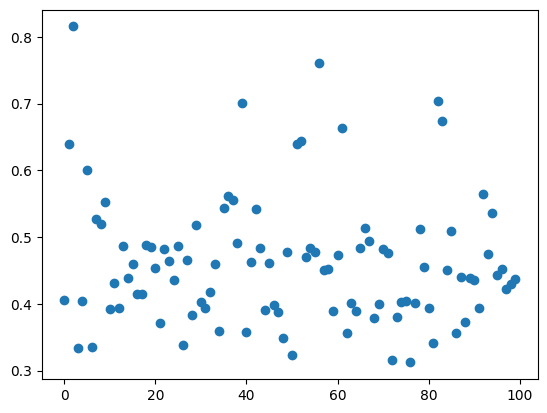

In [ ]:
wer=np.array(wer)
wer=wer/4
print(wer)
import matplotlib.pyplot as plt
plt.scatter([i for i in range(len(wer))],wer)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/ALM_models/ALM_Whisper_test17.pt'
torch.save(pengi.state_dict(), file_path)